In [1]:
# Initialise spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark")\
        .config("spark.driver.memory", "15g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.1")\
        .getOrCreate()

In [2]:
# Importing necessary libraries and packages
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,NGram
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import regexp_replace, trim

from pyspark import keyword_only
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, FloatType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# To install Matplotlib, Wordcloud and NLTK if necessary
import matplotlib
import matplotlib.pyplot as plt
import wordcloud 
from PIL import Image
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/blim001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# File paths for train, test and test labels dataset on HDFS
filepath_train = "hdfs:///user/blim001/jigsaw_dataset/train.csv"
filepath_test = "hdfs:///user/blim001/jigsaw_dataset/test.csv"
filepath_eval = "hdfs:///user/blim001/jigsaw_dataset/test_labels.csv"

# Exploratory Data Analysis

In [4]:
# Create Spark DataFrame from train dataset
df = spark.read.option("quote", "\"")\
.option("escape", "\"").option("multiline", True)\
.option("header", True).csv(filepath_train)

In [5]:
# Check for null values in the train DataFrame
columns = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in columns]).show()

+-----+------------+-------+------+------+-------------+
|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+-----+------------+-------+------+------+-------------+
|    0|           0|      0|     0|     0|            0|
+-----+------------+-------+------+------+-------------+



In [6]:
# Check Schema of the train DataFrame
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: string (nullable = true)
 |-- severe_toxic: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- identity_hate: string (nullable = true)



In [7]:
# Count the number of comments of each toxicity type
columns = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

df.select([F.count(F.when(F.col(c)=='1',c)).alias(c) for c in columns]).show()

# Percentage of comments of each toxicity type
df.select([(F.count(F.when(F.col(c)=='1',c))*100/F.count(F.col(c))).alias(c) for c in columns]).show()

+-----+------------+-------+------+------+-------------+
|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+-----+------------+-------+------+------+-------------+
|15294|        1595|   8449|   478|  7877|         1405|
+-----+------------+-------+------+------+-------------+

+-----------------+------------------+---------------+------------------+-----------------+------------------+
|            toxic|      severe_toxic|        obscene|            threat|           insult|     identity_hate|
+-----------------+------------------+---------------+------------------+-----------------+------------------+
|9.584448302009763|0.9995550569965721|5.2948217407925|0.2995531769557125|4.936360616904074|0.8804858025581089|
+-----------------+------------------+---------------+------------------+-----------------+------------------+



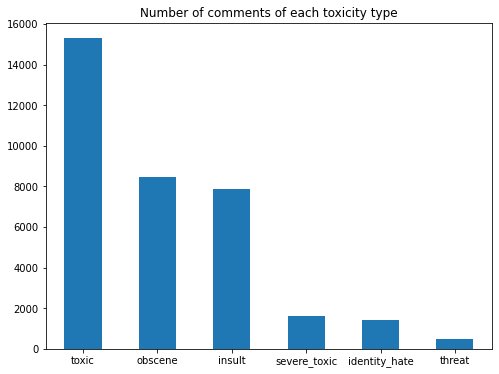

In [8]:
# Plot the counts in a bar plot
fig, ax = plt.subplots(figsize=(8,6))
df_count = df.select([F.count(F.when(F.col(c)=='1',c)).alias(c) for c in columns])
df_pd = df_count.toPandas()
df_pd.transpose().sort_values(by=0,ascending=False).plot.bar(ax=ax, legend=False, rot=0)
ax.set_title("Number of comments of each toxicity type")
plt.show()

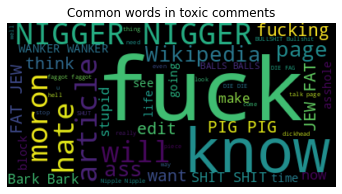

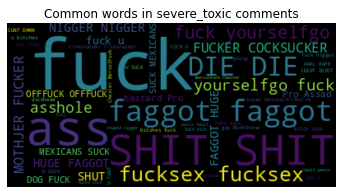

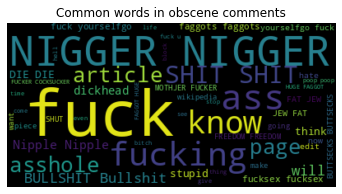

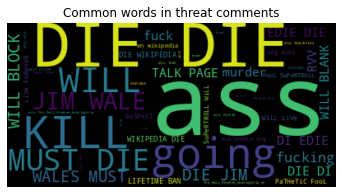

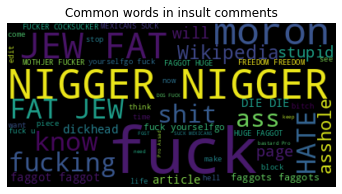

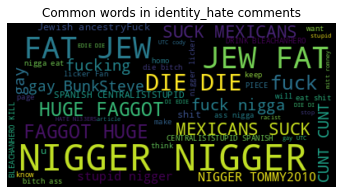

In [9]:
# Generate Word cloud for each toxicity type

def Wordcloud(df, col, n):
    stopwords = set(STOPWORDS)
    stopwords.update(["people", "hi", "go", "one", "say"])
    subset = df[df[col]=="1"].comment_text.values
    texts = " ".join(subset)
    wordcloud = WordCloud(background_color="black", stopwords = stopwords, max_words=50)
    wc = wordcloud.generate(texts)
    
    plt.figure(figsize=(20,20))
    plt.subplot(3,3,n)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title("Common words in {} comments".format(col))
    plt.show()

# Generate plots
df_pandas = df.toPandas()

Wordcloud(df_pandas, "toxic", 1)
Wordcloud(df_pandas, "severe_toxic", 2)
Wordcloud(df_pandas, "obscene", 3)
Wordcloud(df_pandas, "threat", 4)
Wordcloud(df_pandas, "insult", 5)
Wordcloud(df_pandas, "identity_hate", 6)

# Data Preparation

## Preparing train data

In [4]:
# Create DataFrame from train dataset

df = spark.read.option("quote", "\"")\
.option("escape", "\"").option("multiline", True)\
.option("header", True).csv(filepath_train)

In [5]:
# Label Encoding for train DataFrame
inputs = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

outputs = ['toxic_idx', 'severe_toxic_idx', 'obscene_idx', 'threat_idx',
       'insult_idx', 'identity_hate_idx']

labelEncoder = StringIndexer(inputCols=inputs, outputCols=outputs).fit(df)

df = labelEncoder.transform(df)

In [6]:
# Remove punctuations, non-ASCII characters and numbers in the comment texts
df_regex = df.withColumn("column_regex", 
                         trim(
                        (regexp_replace(
                        regexp_replace(
                        regexp_replace(F.col("comment_text"), r'[^\x00-\x7F]', ''), 
                            '[^\sa-zA-Z]', ''), r'\s+', ' '))))

df_regex = df_regex.select('column_regex','toxic_idx', 'severe_toxic_idx', 'obscene_idx', 
                         'threat_idx','insult_idx', 'identity_hate_idx')


print('Total rows in the original train dataset: {}'.format(df_regex.count()))

Total rows in the original train dataset: 159571


### NLP Pipeline

In [7]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import PerceptronModel
from sparknlp.annotator import Chunker
from sparknlp.base import Finisher
from sparknlp.annotator import NGramGenerator


documentAssembler = DocumentAssembler() \
     .setInputCol('column_regex') \
     .setOutputCol('document')

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)
    
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams')


bigram_generator = NGramGenerator() \
    .setInputCols(['unigrams']) \
    .setOutputCol('bigrams') \
    .setN(2)


finisher = Finisher() \
     .setInputCols(['unigrams', 'bigrams'])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [8]:
# Building NLP pipeline
nlp_pipeline = Pipeline().setStages(
                 [documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 bigram_generator,
                 finisher]
)

# Pre-process train dataset using NLP pipeline
df_use = nlp_pipeline.fit(df_regex).transform(df_regex)
df_use.cache()


DataFrame[column_regex: string, toxic_idx: double, severe_toxic_idx: double, obscene_idx: double, threat_idx: double, insult_idx: double, identity_hate_idx: double, finished_unigrams: array<string>, finished_bigrams: array<string>]

### Resampled datasets

In [9]:
# Resampling original dataset for more balanced distribution

# Toxic
df_Tox = df_use.filter(F.col('toxic_idx')==1).union(
        (df_use.filter(F.col('toxic_idx')==0).randomSplit([0.11, 0.89], 42))[0])
df_Tox.cache()
df_Tox.groupBy(F.col('toxic_idx').alias('Toxic comments')).count().show()

# Severe Toxic
df_ST = df_use.filter(F.col('severe_toxic_idx')==1).union(
        (df_use.filter(F.col('severe_toxic_idx')==0).randomSplit([0.01, 0.99], 42))[0])
df_ST.cache()
df_ST.groupBy(F.col('severe_toxic_idx').alias('Severe Toxic comments')).count().show()

# Obscene
df_Ob = df_use.filter(F.col('obscene_idx')==1).union(
        (df_use.filter(F.col('obscene_idx')==0).randomSplit([0.06, 0.94], 42))[0])
df_Ob.cache()
df_Ob.groupBy(F.col('obscene_idx').alias('Obscene comments')).count().show()

# Threat
df_Thr = df_use.filter(F.col('threat_idx')==1).union(
        (df_use.filter(F.col('threat_idx')==0).randomSplit([0.003, 0.997], 42))[0])
df_Thr.cache()
df_Thr.groupBy(F.col('threat_idx').alias('Threat comments')).count().show()

# Insult
df_Ins = df_use.filter(F.col('insult_idx')==1).union(
        (df_use.filter(F.col('insult_idx')==0).randomSplit([0.05, 0.95], 42))[0])
df_Ins.cache()
df_Ins.groupBy(F.col('insult_idx').alias('Insult comments')).count().show()

# Identity Hate
df_IH = df_use.filter(F.col('identity_hate_idx')==1).union(
        (df_use.filter(F.col('identity_hate_idx')==0).randomSplit([0.009, 0.991], 42))[0])
df_IH.cache()
df_IH.groupBy(F.col('identity_hate_idx').alias('Identity Hate comments')).count().show()

+--------------+-----+
|Toxic comments|count|
+--------------+-----+
|           0.0|15760|
|           1.0|15294|
+--------------+-----+

+---------------------+-----+
|Severe Toxic comments|count|
+---------------------+-----+
|                  0.0| 1587|
|                  1.0| 1595|
+---------------------+-----+

+----------------+-----+
|Obscene comments|count|
+----------------+-----+
|             0.0| 8991|
|             1.0| 8449|
+----------------+-----+

+---------------+-----+
|Threat comments|count|
+---------------+-----+
|            0.0|  470|
|            1.0|  478|
+---------------+-----+

+---------------+-----+
|Insult comments|count|
+---------------+-----+
|            0.0| 7532|
|            1.0| 7877|
+---------------+-----+

+----------------------+-----+
|Identity Hate comments|count|
+----------------------+-----+
|                   0.0| 1422|
|                   1.0| 1405|
+----------------------+-----+



## Preparing test data

In [10]:
# Create DataFrame from test dataset
df_test = spark.read.option("quote", "\"")\
.option("escape", "\"").option("multiline", True)\
.option("header", True).csv(filepath_test)


print('Total rows in the test dataset: {}'.format(df_test.count()))

Total rows in the test dataset: 153164


In [11]:
# Remove punctuations, non-ASCII characters and numbers in the comment texts
df_test = df_test.withColumn("column_regex", 
                         trim(
                        (regexp_replace(
                        regexp_replace(
                        regexp_replace(F.col("comment_text"), r'[^\x00-\x7F]', ''), 
                            '[^\sa-zA-Z]', ''), r'\s+', ' ')
                             )))

In [12]:
# Pre-processing test dataset using NLP pipeline
df_test = nlp_pipeline.fit(df_regex).transform(df_test)
df_test.cache()

DataFrame[id: string, comment_text: string, column_regex: string, finished_unigrams: array<string>, finished_bigrams: array<string>]

In [13]:
# Create DataFrame from test labels dataset 
df_eval = spark.read.csv(filepath_eval, inferSchema=True, header=True)

# Filter out instances labelled -1
df_eval = df_eval.filter((df_eval.toxic != -1) & (df_eval.severe_toxic != -1)\
                         & (df_eval.obscene != -1) & (df_eval.threat != -1)\
                         & (df_eval.insult != -1) & (df_eval.identity_hate != -1))

# Label Encoding for test labels DataFrame
df_eval = labelEncoder.transform(df_eval)
df_eval.cache()

print('Total rows in the test labels dataset: {}'.format(df_eval.count()))

Total rows in the test labels dataset: 63978


# Model Training and Evaluation

## Creating ML Pipeline

In [14]:
# ML Pipeline stages

# count vectorizer for model training without bigrams
vectorizer_unigram = CountVectorizer(inputCol='finished_unigrams',outputCol='features_raw')

# count vectorizer for model training with bigrams
vectorizer_bigram = CountVectorizer(inputCol='finished_bigrams',outputCol='features_raw')

# IDF vectorizer
idf = IDF(inputCol='features_raw',outputCol='features_vectorized')

# If using Logistic Regression
lr_Tox = LogisticRegression(featuresCol='features_vectorized',labelCol='toxic_idx')
lr_ST = LogisticRegression(featuresCol='features_vectorized',labelCol='severe_toxic_idx')
lr_Ob = LogisticRegression(featuresCol='features_vectorized',labelCol='obscene_idx')
lr_Thr = LogisticRegression(featuresCol='features_vectorized',labelCol='threat_idx')
lr_Ins = LogisticRegression(featuresCol='features_vectorized',labelCol='insult_idx')
lr_IH = LogisticRegression(featuresCol='features_vectorized',labelCol='identity_hate_idx')

# If using Linear SVC
svm_Tox = LinearSVC(featuresCol='features_vectorized',labelCol='toxic_idx')
svm_ST = LinearSVC(featuresCol='features_vectorized',labelCol='severe_toxic_idx')
svm_Ob = LinearSVC(featuresCol='features_vectorized',labelCol='obscene_idx')
svm_Thr = LinearSVC(featuresCol='features_vectorized',labelCol='threat_idx')
svm_Ins = LinearSVC(featuresCol='features_vectorized',labelCol='insult_idx')
svm_IH = LinearSVC(featuresCol='features_vectorized',labelCol='identity_hate_idx')

# If using Random Forest
rf_Tox = RandomForestClassifier(featuresCol='features_vectorized', labelCol='toxic_idx', seed=42)
rf_ST = RandomForestClassifier(featuresCol='features_vectorized', labelCol='severe_toxic_idx', seed=42)
rf_Ob = RandomForestClassifier(featuresCol='features_vectorized', labelCol='obscene_idx', seed=42)
rf_Thr = RandomForestClassifier(featuresCol='features_vectorized', labelCol='threat_idx', seed=42)
rf_Ins = RandomForestClassifier(featuresCol='features_vectorized', labelCol='insult_idx', seed=42)
rf_IH = RandomForestClassifier(featuresCol='features_vectorized', labelCol='identity_hate_idx', seed=42)



## Training on original dataset

### Logistic Regression

#### Toxic comments

In [21]:
# Toxic comments - Original dataset

pipeline_Tox = Pipeline(stages = [vectorizer_bigram, idf, lr_Tox])

model_Tox_all = pipeline_Tox.fit(df_use)

predictions_Tox_all = model_Tox_all.transform(df_test)

predictions_Tox_all = predictions_Tox_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_Tox = predictions_Tox_all.join(df_eval, "id",'inner').select(predictions_Tox_all.id,
                                                predictions_Tox_all.comment_text,
                                                predictions_Tox_all.probability,
                                                predictions_Tox_all.rawPrediction,
                                                predictions_Tox_all.prediction, 
                                                df_eval.toxic_idx)

pred_Tox.cache()

 
evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1", metricLabel=1.0)  # Label 1 is positive class.

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy", metricLabel=1.0)   # Label 1 is positive class.

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox_all = evaluator_Tox.evaluate(pred_Tox)
print("Test set F1 score for Toxic comments = " + str(f1_Tox_all))
Acc_Tox_all = evaluator_Tox_A.evaluate(pred_Tox)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox_all))
ROC_Tox_all = evaluator_Tox_ROC.evaluate(pred_Tox)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox_all))

pred_Tox.groupBy(F.col('prediction'),F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.891918469034243
Test set Accuracy score for Toxic comments = 0.8907280627715777
Test set Area under ROC for Toxic comments = 0.8302923398992091
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 2747|
|       0.0|      1.0| 3343|
|       1.0|      0.0| 3648|
|       0.0|      0.0|54240|
+----------+---------+-----+



#### Severe Toxic Comments

In [22]:
# Severe Toxic comments - Original dataset

pipeline_ST = Pipeline(stages = [vectorizer_bigram, idf, lr_ST])

model_ST_all = pipeline_ST.fit(df_use)

predictions_ST_all = model_ST_all.transform(df_test)

predictions_ST_all = predictions_ST_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_ST = predictions_ST_all.join(df_eval, "id",'inner').select(predictions_ST_all.id,
                                                predictions_ST_all.comment_text,
                                                predictions_ST_all.probability,
                                                predictions_ST_all.rawPrediction,
                                                predictions_ST_all.prediction, 
                                                df_eval.severe_toxic_idx)

pred_ST.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")


f1_ST_all = evaluator_ST.evaluate(pred_ST)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST_all))
Acc_ST_all = evaluator_ST_A.evaluate(pred_ST)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST_all))
ROC_ST_all = evaluator_ST_ROC.evaluate(pred_ST)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST_all))

pred_ST.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.9873004133370489
Test set Accuracy score for Severe Toxic comments = 0.9840570196004876
Test set Area under ROC for Severe Toxic comments = 0.6928223517285346
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  113|
|       0.0|             1.0|  254|
|       1.0|             0.0|  766|
|       0.0|             0.0|62845|
+----------+----------------+-----+



#### Obscence Comments

In [23]:
# Obscene comments - Original dataset

pipeline_Ob = Pipeline(stages = [vectorizer_bigram, idf, lr_Ob])

model_Ob_all = pipeline_Ob.fit(df_use)

predictions_Ob_all = model_Ob_all.transform(df_test)

predictions_Ob_all = predictions_Ob_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_Ob = predictions_Ob_all.join(df_eval, "id",'inner').select(predictions_Ob_all.id,
                                                predictions_Ob_all.comment_text,
                                                predictions_Ob_all.probability,
                                                predictions_Ob_all.rawPrediction,
                                                predictions_Ob_all.prediction, 
                                                df_eval.obscene_idx)

pred_Ob.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob_all = evaluator_Ob.evaluate(pred_Ob)
print("Test set F1 score for Obscene comments = " + str(f1_Ob_all))
Acc_Ob_all = evaluator_Ob_A.evaluate(pred_Ob)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob_all))
ROC_Ob_all = evaluator_Ob_ROC.evaluate(pred_Ob)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob_all))

pred_Ob.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.9352688607235821
Test set Accuracy score for Obscene comments = 0.935227734533746
Test set Area under ROC for Obscene comments = 0.8378841464806401
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 1624|
|       0.0|        1.0| 2067|
|       1.0|        0.0| 2077|
|       0.0|        0.0|58210|
+----------+-----------+-----+



#### Threat Comments

In [24]:
# Threat comments - Original dataset

pipeline_Thr = Pipeline(stages = [vectorizer_bigram, idf, lr_Thr])

model_Thr_all = pipeline_Thr.fit(df_use)

predictions_Thr_all = model_Thr_all.transform(df_test)

predictions_Thr_all = predictions_Thr_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_Thr = predictions_Thr_all.join(df_eval, "id",'inner').select(predictions_Thr_all.id,
                                                predictions_Thr_all.comment_text,
                                                predictions_Thr_all.probability,
                                                predictions_Thr_all.rawPrediction,
                                                predictions_Thr_all.prediction, 
                                                df_eval.threat_idx)

pred_Thr.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr_all = evaluator_Thr.evaluate(pred_Thr)
print("Test set F1 score for Threat comments = " + str(f1_Thr_all))
Acc_Thr_all = evaluator_Thr_A.evaluate(pred_Thr)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr_all))
ROC_Thr_all = evaluator_Thr_ROC.evaluate(pred_Thr)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr_all))

pred_Thr.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.9937751936431536
Test set Accuracy score for Threat comments = 0.9928725499390415
Test set Area under ROC for Threat comments = 0.7506277482216983
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|   55|
|       0.0|       1.0|  156|
|       1.0|       0.0|  300|
|       0.0|       0.0|63467|
+----------+----------+-----+



#### Insult Comments

In [25]:
# Insult comments - Original dataset

pipeline_Ins = Pipeline(stages = [vectorizer_bigram, idf, lr_Ins])

model_Ins_all = pipeline_Ins.fit(df_use)

predictions_Ins_all = model_Ins_all.transform(df_test)

predictions_Ins_all = predictions_Ins_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_Ins = predictions_Ins_all.join(df_eval, "id",'inner').select(predictions_Ins_all.id,
                                                predictions_Ins_all.comment_text,
                                                predictions_Ins_all.probability,
                                                predictions_Ins_all.rawPrediction,
                                                predictions_Ins_all.prediction, 
                                                df_eval.insult_idx)

pred_Ins.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins_all = evaluator_Ins.evaluate(pred_Ins)
print("Test set F1 score for Insult comments = " + str(f1_Ins_all))
Acc_Ins_all = evaluator_Ins_A.evaluate(pred_Ins)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins_all))
ROC_Ins_all = evaluator_Ins_ROC.evaluate(pred_Ins)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins_all))

pred_Ins.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.9346214859523864
Test set Accuracy score for Insult comments = 0.9351808434149239
Test set Area under ROC for Insult comments = 0.8062091662974974
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 1292|
|       0.0|       1.0| 2135|
|       1.0|       0.0| 2012|
|       0.0|       0.0|58539|
+----------+----------+-----+



#### Identity Hate Comments

In [26]:
# Identity Hate comments - Original dataset

pipeline_IH = Pipeline(stages = [vectorizer_bigram, idf, lr_IH])

model_IH_all = pipeline_IH.fit(df_use)

predictions_IH_all = model_IH_all.transform(df_test)

predictions_IH_all = predictions_IH_all.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_IH = predictions_IH_all.join(df_eval, "id",'inner').select(predictions_IH_all.id,
                                                predictions_IH_all.comment_text,
                                                predictions_IH_all.probability,
                                                predictions_IH_all.rawPrediction,
                                                predictions_IH_all.prediction, 
                                                df_eval.identity_hate_idx)

pred_IH.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH_all = evaluator_IH.evaluate(pred_IH)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH_all))
Acc_IH_all = evaluator_IH_A.evaluate(pred_IH)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH_all ))
ROC_IH_all = evaluator_IH_ROC.evaluate(pred_IH)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH_all))

pred_IH.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.9815263681684815
Test set Accuracy score for Identity Hate comments = 0.9811497702335178
Test set Area under ROC for Identity Hate comments = 0.7460247099192738
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  139|
|       0.0|              1.0|  573|
|       1.0|              0.0|  633|
|       0.0|              0.0|62633|
+----------+-----------------+-----+



## Training on resampled datasets

### Logistic Regression - with Bigrams

#### Toxic Comments

In [27]:
# Toxic comments - Resampled dataset (with Bigrams)

pipeline_Tox = Pipeline(stages = [vectorizer_bigram, idf, lr_Tox])

model_Tox = pipeline_Tox.fit(df_Tox)

predictions_Tox = model_Tox.transform(df_test)

predictions_Tox = predictions_Tox.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Tox = predictions_Tox.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox.id,
                                                predictions_Tox.comment_text,
                                                predictions_Tox.probability,
                                                predictions_Tox.rawPrediction,
                                                predictions_Tox.prediction, 
                                                df_eval.toxic_idx)
pred_final_Tox.cache()


evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox = evaluator_Tox.evaluate(pred_final_Tox)
print("Test set F1 score for Toxic comments = " + str(f1_Tox))

Acc_Tox = evaluator_Tox_A.evaluate(pred_final_Tox)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox))

ROC_Tox = evaluator_Tox_ROC.evaluate(pred_final_Tox)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox))

pred_final_Tox.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.7580819511091986
Test set Accuracy score for Toxic comments = 0.6955672262340179
Test set Area under ROC for Toxic comments = 0.8107832243975337
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 4896|
|       0.0|      1.0| 1194|
|       1.0|      0.0|18283|
|       0.0|      0.0|39605|
+----------+---------+-----+



#### Severe Toxic Comments

In [28]:
# Severe Toxic comments - Resampled dataset (with Bigrams)

pipeline_ST = Pipeline(stages = [vectorizer_bigram, idf, lr_ST])

model_ST = pipeline_ST.fit(df_ST)

predictions_ST = model_ST.transform(df_test)

predictions_ST = predictions_ST.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_ST = predictions_ST.join(df_eval, "id",'inner').select(predictions_ST.id,
                                                predictions_ST.comment_text,
                                                predictions_ST.probability,
                                                predictions_ST.rawPrediction,
                                                predictions_ST.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST = evaluator_ST.evaluate(pred_final_ST)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST))
Acc_ST = evaluator_ST_A.evaluate(pred_final_ST)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST))
ROC_ST = evaluator_ST_ROC.evaluate(pred_final_ST)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST))

pred_final_ST.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.9192709952032971
Test set Accuracy score for Severe Toxic comments = 0.8597642939760543
Test set Area under ROC for Severe Toxic comments = 0.9010828418662037
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  298|
|       0.0|             1.0|   69|
|       1.0|             0.0| 8903|
|       0.0|             0.0|54708|
+----------+----------------+-----+



#### Obscene Comments

In [29]:
# Obscene comments - Resampled dataset (with Bigrams)

pipeline_Ob = Pipeline(stages = [vectorizer_bigram, idf, lr_Ob])

model_Ob = pipeline_Ob.fit(df_Ob)

predictions_Ob = model_Ob.transform(df_test)

predictions_Ob = predictions_Ob.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ob = predictions_Ob.join(df_eval, "id",'inner').select(predictions_Ob.id,
                                                predictions_Ob.comment_text,
                                                predictions_Ob.probability,
                                                predictions_Ob.rawPrediction,
                                                predictions_Ob.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob = evaluator_Ob.evaluate(pred_final_Ob)
print("Test set F1 score for Obscene comments = " + str(f1_Ob))
Acc_Ob = evaluator_Ob_A.evaluate(pred_final_Ob)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob))
ROC_Ob = evaluator_Ob_ROC.evaluate(pred_final_Ob)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob))

pred_final_Ob.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.8649950998365812
Test set Accuracy score for Obscene comments = 0.8239551095689143
Test set Area under ROC for Obscene comments = 0.8373617154325534
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 2491|
|       0.0|        1.0| 1200|
|       1.0|        0.0|10063|
|       0.0|        0.0|50224|
+----------+-----------+-----+



#### Threat Comments

In [30]:
# Threat comments - Resampled dataset (with Bigrams)

pipeline_Thr = Pipeline(stages = [vectorizer_bigram, idf, lr_Thr])

model_Thr = pipeline_Thr.fit(df_Thr)

predictions_Thr = model_Thr.transform(df_test)

predictions_Thr = predictions_Thr.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Thr = predictions_Thr.join(df_eval, "id",'inner').select(predictions_Thr.id,
                                                predictions_Thr.comment_text,
                                                predictions_Thr.probability,
                                                predictions_Thr.rawPrediction,
                                                predictions_Thr.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr = evaluator_Thr.evaluate(pred_final_Thr)
print("Test set F1 score for Threat comments = " + str(f1_Thr))
Acc_Thr = evaluator_Thr_A.evaluate(pred_final_Thr)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr))
ROC_Thr = evaluator_Thr_ROC.evaluate(pred_final_Thr)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr))

pred_final_Thr.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.9459114706376918
Test set Accuracy score for Threat comments = 0.9029822751570853
Test set Area under ROC for Threat comments = 0.867378177825566
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  126|
|       0.0|       1.0|   85|
|       1.0|       0.0| 6122|
|       0.0|       0.0|57645|
+----------+----------+-----+



#### Insult Comments 

In [31]:
# Insult comments - Resampled dataset (with Bigrams)

pipeline_Ins = Pipeline(stages = [vectorizer_bigram, idf, lr_Ins])

model_Ins = pipeline_Ins.fit(df_Ins)

predictions_Ins = model_Ins.transform(df_test)

predictions_Ins = predictions_Ins.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ins = predictions_Ins.join(df_eval, "id",'inner').select(predictions_Ins.id,
                                                predictions_Ins.comment_text,
                                                predictions_Ins.probability,
                                                predictions_Ins.rawPrediction,
                                                predictions_Ins.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins = evaluator_Ins.evaluate(pred_final_Ins)
print("Test set F1 score for Insult comments = " + str(f1_Ins))
Acc_Ins = evaluator_Ins_A.evaluate(pred_final_Ins)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins))
ROC_Ins = evaluator_Ins_ROC.evaluate(pred_final_Ins)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins))

pred_final_Ins.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.7667775203601731
Test set Accuracy score for Insult comments = 0.6787333145768858
Test set Area under ROC for Insult comments = 0.8306367437092624
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 2871|
|       0.0|       1.0|  556|
|       1.0|       0.0|19998|
|       0.0|       0.0|40553|
+----------+----------+-----+



#### Identity Hate Comments 

In [32]:
# Identity Hate comments - Resampled dataset (with Bigrams)

pipeline_IH = Pipeline(stages = [vectorizer_bigram, idf, lr_IH])

model_IH = pipeline_IH.fit(df_IH)

predictions_IH = model_IH.transform(df_test)

predictions_IH = predictions_IH.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_IH = predictions_IH.join(df_eval, "id",'inner').select(predictions_IH.id,
                                                predictions_IH.comment_text,
                                                predictions_IH.probability,
                                                predictions_IH.rawPrediction,
                                                predictions_IH.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH = evaluator_IH.evaluate(pred_final_IH)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH))
Acc_IH = evaluator_IH_A.evaluate(pred_final_IH)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH))
ROC_IH = evaluator_IH_ROC.evaluate(pred_final_IH)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH))

pred_final_IH.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.9010520068672321
Test set Accuracy score for Identity Hate comments = 0.8365375597861765
Test set Area under ROC for Identity Hate comments = 0.8278777216546355
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  428|
|       0.0|              1.0|  284|
|       1.0|              0.0|10174|
|       0.0|              0.0|53092|
+----------+-----------------+-----+



### Logistic Regression - without Bigrams

#### Toxic Comments

In [33]:
# Toxic comments - Resampled dataset (w/o Bigrams)
pipeline_Tox1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Tox])

model_Tox1 = pipeline_Tox1.fit(df_Tox)

predictions_Tox1 = model_Tox1.transform(df_test)

predictions_Tox1 = predictions_Tox1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Tox1 = predictions_Tox1.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox1.id,
                                                predictions_Tox1.comment_text,
                                                predictions_Tox1.probability,
                                                predictions_Tox1.rawPrediction,
                                                predictions_Tox1.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox1.cache()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox1 = evaluator_Tox.evaluate(pred_final_Tox1)
print("Test set F1 score for Toxic comments = " + str(f1_Tox1))

Acc_Tox1 = evaluator_Tox_A.evaluate(pred_final_Tox1)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox1))

ROC_Tox1 = evaluator_Tox_ROC.evaluate(pred_final_Tox1)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox1))

pred_final_Tox1.groupBy(F.col('prediction'),F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.7567866645804956
Test set Accuracy score for Toxic comments = 0.6939729281940668
Test set Area under ROC for Toxic comments = 0.7827355919612845
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 4806|
|       0.0|      1.0| 1284|
|       1.0|      0.0|18295|
|       0.0|      0.0|39593|
+----------+---------+-----+



#### Severe Toxic Comments

In [34]:
# Severe Toxic comments - Resampled dataset (w/o Bigrams)

pipeline_ST1 = Pipeline(stages = [vectorizer_unigram, idf, lr_ST])

model_ST1 = pipeline_ST1.fit(df_ST)

predictions_ST1 = model_ST1.transform(df_test)

predictions_ST1 = predictions_ST1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_ST1 = predictions_ST1.join(df_eval, "id",'inner').select(predictions_ST1.id,
                                                predictions_ST1.comment_text,
                                                predictions_ST1.probability,
                                                predictions_ST1.rawPrediction,
                                                predictions_ST1.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST1.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST1 = evaluator_ST.evaluate(pred_final_ST1)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST1))
Acc_ST1 = evaluator_ST_A.evaluate(pred_final_ST1)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST1))
ROC_ST1 = evaluator_ST_ROC.evaluate(pred_final_ST1)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST1))

pred_final_ST1.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.8085184510530671
Test set Accuracy score for Severe Toxic comments = 0.6864859795554722
Test set Area under ROC for Severe Toxic comments = 0.8470021957798091
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  316|
|       0.0|             1.0|   51|
|       1.0|             0.0|20007|
|       0.0|             0.0|43604|
+----------+----------------+-----+



#### Obscene Comments

In [35]:
# Obscene comments - Resampled dataset (w/o Bigrams)

pipeline_Ob1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Ob])

model_Ob1 = pipeline_Ob1.fit(df_Ob)

predictions_Ob1 = model_Ob1.transform(df_test)

predictions_Ob1 = predictions_Ob1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ob1 = predictions_Ob1.join(df_eval, "id",'inner').select(predictions_Ob1.id,
                                                predictions_Ob1.comment_text,
                                                predictions_Ob1.probability,
                                                predictions_Ob1.rawPrediction,
                                                predictions_Ob1.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob1.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob1 = evaluator_Ob.evaluate(pred_final_Ob1)
print("Test set F1 score for Obscene comments = " + str(f1_Ob1))
Acc_Ob1 = evaluator_Ob_A.evaluate(pred_final_Ob1)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob1))
ROC_Ob1 = evaluator_Ob_ROC.evaluate(pred_final_Ob1)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob1))

pred_final_Ob1.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.7712534762266305
Test set Accuracy score for Obscene comments = 0.68800212573072
Test set Area under ROC for Obscene comments = 0.7705109529884102
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 2791|
|       0.0|        1.0|  900|
|       1.0|        0.0|19061|
|       0.0|        0.0|41226|
+----------+-----------+-----+



#### Threat Comments

In [36]:
# Threat comments - Resampled dataset (w/o Bigrams)

pipeline_Thr1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Thr])

model_Thr1 = pipeline_Thr1.fit(df_Thr)

predictions_Thr1 = model_Thr1.transform(df_test)

predictions_Thr1 = predictions_Thr1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Thr1 = predictions_Thr1.join(df_eval, "id",'inner').select(predictions_Thr1.id,
                                                predictions_Thr1.comment_text,
                                                predictions_Thr1.probability,
                                                predictions_Thr1.rawPrediction,
                                                predictions_Thr1.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr1.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr1 = evaluator_Thr.evaluate(pred_final_Thr1)
print("Test set F1 score for Threat comments = " + str(f1_Thr1))
Acc_Thr1 = evaluator_Thr_A.evaluate(pred_final_Thr1)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr1))
ROC_Thr1 = evaluator_Thr_ROC.evaluate(pred_final_Thr1)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr1))

pred_final_Thr1.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.847738015474555
Test set Accuracy score for Threat comments = 0.7405045484385258
Test set Area under ROC for Threat comments = 0.788132773366189
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  159|
|       0.0|       1.0|   52|
|       1.0|       0.0|16550|
|       0.0|       0.0|47217|
+----------+----------+-----+



#### Insult Comments

In [37]:
# Insult comments - Resampled dataset (w/o Bigrams)

pipeline_Ins1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Ins])

model_Ins1 = pipeline_Ins1.fit(df_Ins)

predictions_Ins1 = model_Ins1.transform(df_test)

predictions_Ins1 = predictions_Ins1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ins1 = predictions_Ins1.join(df_eval, "id",'inner').select(predictions_Ins1.id,
                                                predictions_Ins1.comment_text,
                                                predictions_Ins1.probability,
                                                predictions_Ins1.rawPrediction,
                                                predictions_Ins1.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins1.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins1 = evaluator_Ins.evaluate(pred_final_Ins1)
print("Test set F1 score for Insult comments = " + str(f1_Ins1))
Acc_Ins1 = evaluator_Ins_A.evaluate(pred_final_Ins1)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins1))
ROC_Ins1 = evaluator_Ins_ROC.evaluate(pred_final_Ins1)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins1))

pred_final_Ins1.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.7672766187531409
Test set Accuracy score for Insult comments = 0.6793272687486324
Test set Area under ROC for Insult comments = 0.7944047046373971
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 2764|
|       0.0|       1.0|  663|
|       1.0|       0.0|19853|
|       0.0|       0.0|40698|
+----------+----------+-----+



#### Identity Hate Comments

In [38]:
# Identity Hate comments - Resampled dataset (w/o Bigrams)

pipeline_IH1 = Pipeline(stages = [vectorizer_unigram, idf, lr_IH])

model_IH1 = pipeline_IH1.fit(df_IH)

predictions_IH1 = model_IH1.transform(df_test)

predictions_IH1 = predictions_IH1.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_IH1 = predictions_IH1.join(df_eval, "id",'inner').select(predictions_IH1.id,
                                                predictions_IH1.comment_text,
                                                predictions_IH1.probability,
                                                predictions_IH1.rawPrediction,
                                                predictions_IH1.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH1.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH1 = evaluator_IH.evaluate(pred_final_IH1)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH1))
Acc_IH1 = evaluator_IH_A.evaluate(pred_final_IH1)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH1))
ROC_IH1 = evaluator_IH_ROC.evaluate(pred_final_IH1)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH1))

pred_final_IH1.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.7641145920223457
Test set Accuracy score for Identity Hate comments = 0.6323579980618338
Test set Area under ROC for Identity Hate comments = 0.8078542861831475
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  598|
|       0.0|              1.0|  114|
|       1.0|              0.0|23407|
|       0.0|              0.0|39859|
+----------+-----------------+-----+



#### Summary Results of Logistic Regression Resampled datasets (with Bigrams)

In [39]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_lr_Bg = spark.createDataFrame(
    [
        ("Toxic", f1_Tox, Acc_Tox, ROC_Tox),
        ("Severe Toxic", f1_ST, Acc_ST, ROC_ST),
        ("Obscene", f1_Ob, Acc_Ob, ROC_Ob),
        ("Threat", f1_Thr, Acc_Thr, ROC_Thr),
        ("Insult", f1_Ins, Acc_Ins, ROC_Ins),
        ("Indentity Hate", f1_IH, Acc_IH, ROC_IH)
    ], 
    schema=schema)

stats_lr_Bg.show()

+--------------+----------+--------------+--------------+
|      Category|  F1 Score|Accuracy Score|Area under ROC|
+--------------+----------+--------------+--------------+
|         Toxic|  0.758082|    0.69556725|     0.8107832|
|  Severe Toxic|  0.919271|     0.8597643|     0.9010828|
|       Obscene| 0.8649951|     0.8239551|     0.8373617|
|        Threat|0.94591147|     0.9029823|     0.8673782|
|        Insult| 0.7667775|     0.6787333|    0.83063674|
|Indentity Hate|  0.901052|    0.83653754|     0.8278777|
+--------------+----------+--------------+--------------+



#### Summary Results of Logistic Regression Resampled datasets (w/o Bigrams)

In [40]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_lr = spark.createDataFrame(
    [
        ("Toxic", f1_Tox1, Acc_Tox1, ROC_Tox1),
        ("Severe Toxic", f1_ST1, Acc_ST1, ROC_ST1),
        ("Obscene", f1_Ob1, Acc_Ob1, ROC_Ob1),
        ("Threat", f1_Thr1, Acc_Thr1, ROC_Thr1),
        ("Insult", f1_Ins1, Acc_Ins1, ROC_Ins1),
        ("Indentity Hate", f1_IH1, Acc_IH1, ROC_IH1)
    ], 
    schema=schema)

stats_lr.show()

+--------------+----------+--------------+--------------+
|      Category|  F1 Score|Accuracy Score|Area under ROC|
+--------------+----------+--------------+--------------+
|         Toxic|0.75678664|    0.69397295|     0.7827356|
|  Severe Toxic|0.80851847|      0.686486|     0.8470022|
|       Obscene|0.77125347|     0.6880021|      0.770511|
|        Threat|  0.847738|    0.74050456|     0.7881328|
|        Insult|0.76727664|    0.67932725|     0.7944047|
|Indentity Hate| 0.7641146|      0.632358|     0.8078543|
+--------------+----------+--------------+--------------+



### Linear SVC - with Bigrams

#### Toxic Comments

In [41]:
# Toxic comments - Resampled dataset (with Bigrams)

pipeline_Tox2 = Pipeline(stages = [vectorizer_bigram, idf, svm_Tox])

model_Tox2 = pipeline_Tox2.fit(df_Tox)

predictions_Tox2 = model_Tox2.transform(df_test)

predictions_Tox2 = predictions_Tox2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Tox2 = predictions_Tox2.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox2.id,
                                                predictions_Tox2.comment_text,
                                                predictions_Tox2.rawPrediction,
                                                predictions_Tox2.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox2.cache()


evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox2 = evaluator_Tox.evaluate(pred_final_Tox2)
print("Test set F1 score for Toxic comments = " + str(f1_Tox2))

Acc_Tox2 = evaluator_Tox_A.evaluate(pred_final_Tox2)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox2))

ROC_Tox2 = evaluator_Tox_ROC.evaluate(pred_final_Tox2)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox2))

pred_final_Tox2.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.6899913215785639
Test set Accuracy score for Toxic comments = 0.6113976679483573
Test set Area under ROC for Toxic comments = 0.8313842224405245
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 5342|
|       0.0|      1.0|  748|
|       1.0|      0.0|24114|
|       0.0|      0.0|33774|
+----------+---------+-----+



#### Severe Toxic Comments

In [42]:
# Severe comments - Resampled dataset (with Bigrams)

pipeline_ST2 = Pipeline(stages = [vectorizer_bigram, idf, svm_ST])

model_ST2 = pipeline_ST2.fit(df_ST)

predictions_ST2 = model_ST2.transform(df_test)

predictions_ST2 = predictions_ST2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_ST2 = predictions_ST2.join(df_eval, "id",'inner')\
                                                .select(predictions_ST2.id,
                                                predictions_ST2.comment_text,
                                                predictions_ST2.rawPrediction,
                                                predictions_ST2.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST2.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST2 = evaluator_ST.evaluate(pred_final_ST2)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST2))

Acc_ST2 = evaluator_ST_A.evaluate(pred_final_ST2)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST2))

ROC_ST2 = evaluator_ST_ROC.evaluate(pred_final_ST2)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST2))

pred_final_ST2.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.5068131896577701
Test set Accuracy score for Severe Toxic comments = 0.34565006721060365
Test set Area under ROC for Severe Toxic comments = 0.9208994751263424
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  359|
|       0.0|             1.0|    8|
|       1.0|             0.0|41856|
|       0.0|             0.0|21755|
+----------+----------------+-----+



#### Obscene Comments

In [43]:
# Obscene comments - Resampled dataset (with Bigrams)

pipeline_Ob2 = Pipeline(stages = [vectorizer_bigram, idf, svm_Ob])

model_Ob2 = pipeline_Ob2.fit(df_Ob)

predictions_Ob2 = model_Ob2.transform(df_test)

predictions_Ob2 = predictions_Ob2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ob2 = predictions_Ob2.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob2.id,
                                                predictions_Ob2.comment_text,
                                                predictions_Ob2.rawPrediction,
                                                predictions_Ob2.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob2.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob2 = evaluator_Ob.evaluate(pred_final_Ob2)
print("Test set F1 score for Obscene comments = " + str(f1_Ob2))

Acc_Ob2 = evaluator_Ob_A.evaluate(pred_final_Ob2)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob2))

ROC_Ob2 = evaluator_Ob_ROC.evaluate(pred_final_Ob2)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob2))

pred_final_Ob2.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.7281405574924665
Test set Accuracy score for Obscene comments = 0.6320141298571383
Test set Area under ROC for Obscene comments = 0.863663795984058
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 3295|
|       0.0|        1.0|  396|
|       1.0|        0.0|23147|
|       0.0|        0.0|37140|
+----------+-----------+-----+



#### Threat Comments

In [44]:
# Threat comments - Resampled dataset (with Bigrams)

pipeline_Thr2 = Pipeline(stages = [vectorizer_bigram, idf, svm_Thr])

model_Thr2 = pipeline_Thr2.fit(df_Thr)

predictions_Thr2 = model_Thr2.transform(df_test)

predictions_Thr2 = predictions_Thr2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Thr2 = predictions_Thr2.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr2.id,
                                                predictions_Thr2.comment_text,
                                                predictions_Thr2.rawPrediction,
                                                predictions_Thr2.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr2.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr2 = evaluator_Thr.evaluate(pred_final_Thr2)
print("Test set F1 score for Threat comments = " + str(f1_Thr2))

Acc_Thr2 = evaluator_Thr_A.evaluate(pred_final_Thr2)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr2))

ROC_Thr2 = evaluator_Thr_ROC.evaluate(pred_final_Thr2)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr2))

pred_final_Thr2.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.9206338173181396
Test set Accuracy score for Threat comments = 0.85832629966551
Test set Area under ROC for Threat comments = 0.8699166701164777
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  143|
|       0.0|       1.0|   68|
|       1.0|       0.0| 8996|
|       0.0|       0.0|54771|
+----------+----------+-----+



#### Insult Comments 

In [45]:
# Insult comments - Resampled dataset (with Bigrams)

pipeline_Ins2 = Pipeline(stages = [vectorizer_bigram, idf, svm_Ins])

model_Ins2 = pipeline_Ins2.fit(df_Ins)

predictions_Ins2 = model_Ins2.transform(df_test)

predictions_Ins2 = predictions_Ins2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ins2 = predictions_Ins2.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins2.id,
                                                predictions_Ins2.comment_text,
                                                predictions_Ins2.rawPrediction,
                                                predictions_Ins2.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins2.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins2 = evaluator_Ins.evaluate(pred_final_Ins2)
print("Test set F1 score for Insult comments = " + str(f1_Ins2))

Acc_Ins2 = evaluator_Ins_A.evaluate(pred_final_Ins2)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins2))

ROC_Ins2 = evaluator_Ins_ROC.evaluate(pred_final_Ins2)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins2))

pred_final_Ins2.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.6407609052339341
Test set Accuracy score for Insult comments = 0.5253680952827534
Test set Area under ROC for Insult comments = 0.8511637996011109
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3164|
|       0.0|       1.0|  263|
|       1.0|       0.0|30103|
|       0.0|       0.0|30448|
+----------+----------+-----+



#### Identity Hate Comments 

In [46]:
# Identity Hate comments - Resampled dataset (with Bigrams)

pipeline_IH2 = Pipeline(stages = [vectorizer_bigram, idf, svm_IH])

model_IH2 = pipeline_IH2.fit(df_IH)

predictions_IH2 = model_IH2.transform(df_test)

predictions_IH2 = predictions_IH2.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_IH2 = predictions_IH2.join(df_eval, "id",'inner')\
                                                .select(predictions_IH2.id,
                                                predictions_IH2.comment_text,
                                                predictions_IH2.rawPrediction,
                                                predictions_IH2.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH2.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH2 = evaluator_IH.evaluate(pred_final_IH2)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH2))

Acc_IH2 = evaluator_IH_A.evaluate(pred_final_IH2)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH2))

ROC_IH2 = evaluator_IH_ROC.evaluate(pred_final_IH2)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH2))

pred_final_IH2.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.9088445984366853
Test set Accuracy score for Identity Hate comments = 0.8496983338022446
Test set Area under ROC for Identity Hate comments = 0.8400834651411193
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  432|
|       0.0|              1.0|  280|
|       1.0|              0.0| 9336|
|       0.0|              0.0|53930|
+----------+-----------------+-----+



### Linear SVC - without Bigrams

#### Toxic Comments

In [47]:
# Toxic comments - Resampled dataset (w/o Bigrams)

pipeline_Tox3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Tox])

model_Tox3 = pipeline_Tox3.fit(df_Tox)

predictions_Tox3 = model_Tox3.transform(df_test)

predictions_Tox3 = predictions_Tox3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Tox3 = predictions_Tox3.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox3.id,
                                                predictions_Tox3.comment_text,
                                                predictions_Tox3.rawPrediction,
                                                predictions_Tox3.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox3.cache()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox3 = evaluator_Tox.evaluate(pred_final_Tox3)
print("Test set F1 score for Toxic comments = " + str(f1_Tox3))

Acc_Tox3 = evaluator_Tox_A.evaluate(pred_final_Tox3)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox3))

ROC_Tox3 = evaluator_Tox_ROC.evaluate(pred_final_Tox3)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox3))

pred_final_Tox3.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.8608657105352451
Test set Accuracy score for Toxic comments = 0.831066929256932
Test set Area under ROC for Toxic comments = 0.9272068051573052
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 5566|
|       0.0|      1.0|  524|
|       1.0|      0.0|10284|
|       0.0|      0.0|47604|
+----------+---------+-----+



#### Severe Toxic Comments

In [48]:
# Severe Toxic comments - Resampled dataset (w/o Bigrams)

pipeline_ST3 = Pipeline(stages = [vectorizer_unigram, idf, svm_ST])

model_ST3 = pipeline_ST3.fit(df_ST)

predictions_ST3 = model_ST3.transform(df_test)

predictions_ST3 = predictions_ST3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_ST3 = predictions_ST3.join(df_eval, "id",'inner')\
                                                .select(predictions_ST3.id,
                                                predictions_ST3.comment_text,
                                                predictions_ST3.rawPrediction,
                                                predictions_ST3.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST3.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST3 = evaluator_ST.evaluate(pred_final_ST3)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST3))

Acc_ST3 = evaluator_ST_A.evaluate(pred_final_ST3)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST3))

ROC_ST3 = evaluator_ST_ROC.evaluate(pred_final_ST3)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST3))

pred_final_ST3.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.7951751832406257
Test set Accuracy score for Severe Toxic comments = 0.6678545750101598
Test set Area under ROC for Severe Toxic comments = 0.9103234205761154
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  338|
|       0.0|             1.0|   29|
|       1.0|             0.0|21221|
|       0.0|             0.0|42390|
+----------+----------------+-----+



#### Obscene Comments

In [49]:
# Obscene comments - Resampled dataset (w/o Bigrams)

pipeline_Ob3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Ob])

model_Ob3 = pipeline_Ob3.fit(df_Ob)

predictions_Ob3 = model_Ob3.transform(df_test)

predictions_Ob3 = predictions_Ob3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ob3 = predictions_Ob3.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob3.id,
                                                predictions_Ob3.comment_text,
                                                predictions_Ob3.rawPrediction,
                                                predictions_Ob3.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob3.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob3 = evaluator_Ob.evaluate(pred_final_Ob3)
print("Test set F1 score for Obscene comments = " + str(f1_Ob3))

Acc_Ob3 = evaluator_Ob_A.evaluate(pred_final_Ob3)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob3))

ROC_Ob3 = evaluator_Ob_ROC.evaluate(pred_final_Ob3)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob3))

pred_final_Ob3.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.9040341872045804
Test set Accuracy score for Obscene comments = 0.8781299821813748
Test set Area under ROC for Obscene comments = 0.9452758993503434
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 3293|
|       0.0|        1.0|  398|
|       1.0|        0.0| 7399|
|       0.0|        0.0|52888|
+----------+-----------+-----+



#### Threat Comments

In [50]:
# Threat comments - Resampled dataset (w/o Bigrams)

pipeline_Thr3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Thr])

model_Thr3 = pipeline_Thr3.fit(df_Thr)

predictions_Thr3 = model_Thr3.transform(df_test)

predictions_Thr3 = predictions_Thr3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Thr3 = predictions_Thr3.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr3.id,
                                                predictions_Thr3.comment_text,
                                                predictions_Thr3.rawPrediction,
                                                predictions_Thr3.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr3.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr3 = evaluator_Thr.evaluate(pred_final_Thr3)
print("Test set F1 score for Threat comments = " + str(f1_Thr3))

Acc_Thr3 = evaluator_Thr_A.evaluate(pred_final_Thr3)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr3))

ROC_Thr3 = evaluator_Thr_ROC.evaluate(pred_final_Thr3)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr3))

pred_final_Thr3.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.7908064505506398
Test set Accuracy score for Threat comments = 0.6585857638563256
Test set Area under ROC for Threat comments = 0.9453490220654501
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  203|
|       0.0|       1.0|    8|
|       1.0|       0.0|21835|
|       0.0|       0.0|41932|
+----------+----------+-----+



#### Insult Comments

In [51]:
# Insult comments - Resampled dataset (w/o Bigrams)

pipeline_Ins3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Ins])

model_Ins3 = pipeline_Ins3.fit(df_Ins)

predictions_Ins3 = model_Ins3.transform(df_test)

predictions_Ins3 = predictions_Ins3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ins3 = predictions_Ins3.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins3.id,
                                                predictions_Ins3.comment_text,
                                                predictions_Ins3.rawPrediction,
                                                predictions_Ins3.prediction, 
                                                df_eval.insult_idx)


pred_final_Ins3.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins3 = evaluator_Ins.evaluate(pred_final_Ins3)
print("Test set F1 score for Insult comments = " + str(f1_Ins3))

Acc_Ins3 = evaluator_Ins_A.evaluate(pred_final_Ins3)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins3))

ROC_Ins3 = evaluator_Ins_ROC.evaluate(pred_final_Ins3)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins3))

pred_final_Ins3.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.8672915995191014
Test set Accuracy score for Insult comments = 0.821532401763106
Test set Area under ROC for Insult comments = 0.9259818681835085
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3075|
|       0.0|       1.0|  352|
|       1.0|       0.0|11066|
|       0.0|       0.0|49485|
+----------+----------+-----+



#### Identity Hate Comments

In [52]:
# Identity Hate comments - Resampled dataset (w/o Bigrams)

pipeline_IH3 = Pipeline(stages = [vectorizer_unigram, idf, svm_IH])

model_IH3 = pipeline_IH3.fit(df_IH)

predictions_IH3 = model_IH3.transform(df_test)

predictions_IH3 = predictions_IH3.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_IH3 = predictions_IH3.join(df_eval, "id",'inner')\
                                                .select(predictions_IH3.id,
                                                predictions_IH3.comment_text,
                                                predictions_IH3.rawPrediction,
                                                predictions_IH3.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH3.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH3 = evaluator_IH.evaluate(pred_final_IH3)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH3))

Acc_IH3 = evaluator_IH_A.evaluate(pred_final_IH3)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH3))

ROC_IH3 = evaluator_IH_ROC.evaluate(pred_final_IH3)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH3))

pred_final_IH3.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.8273851381252605
Test set Accuracy score for Identity Hate comments = 0.7210447341273563
Test set Area under ROC for Identity Hate comments = 0.9317085641079577
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  674|
|       0.0|              1.0|   38|
|       1.0|              0.0|17809|
|       0.0|              0.0|45457|
+----------+-----------------+-----+



#### Summary Results of SVM Resampled datasets (with Bigrams)

In [53]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_svm_Bg = spark.createDataFrame(
    [
        ("Toxic", f1_Tox2, Acc_Tox2, ROC_Tox2),
        ("Severe Toxic", f1_ST2, Acc_ST2, ROC_ST2),
        ("Obscene", f1_Ob2, Acc_Ob2, ROC_Ob2),
        ("Threat", f1_Thr2, Acc_Thr2, ROC_Thr2),
        ("Insult", f1_Ins2, Acc_Ins2, ROC_Ins2),
        ("Indentity Hate", f1_IH2, Acc_IH2, ROC_IH2)
    ], 
    schema=schema)

stats_svm_Bg.show()

+--------------+----------+--------------+--------------+
|      Category|  F1 Score|Accuracy Score|Area under ROC|
+--------------+----------+--------------+--------------+
|         Toxic| 0.6899913|     0.6113977|    0.83138424|
|  Severe Toxic|0.50681317|    0.34565008|    0.92089945|
|       Obscene|0.72814053|    0.63201416|     0.8636638|
|        Threat| 0.9206338|     0.8583263|     0.8699167|
|        Insult| 0.6407609|     0.5253681|     0.8511638|
|Indentity Hate| 0.9088446|     0.8496983|     0.8400835|
+--------------+----------+--------------+--------------+



#### Summary Results of SVM Resampled datasets (w/o Bigrams)

In [54]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_svm = spark.createDataFrame(
    [
        ("Toxic", f1_Tox3, Acc_Tox3, ROC_Tox3),
        ("Severe Toxic", f1_ST3, Acc_ST3, ROC_ST3),
        ("Obscene", f1_Ob3, Acc_Ob3, ROC_Ob3),
        ("Threat", f1_Thr3, Acc_Thr3, ROC_Thr3),
        ("Insult", f1_Ins3, Acc_Ins3, ROC_Ins3),
        ("Indentity Hate", f1_IH3, Acc_IH3, ROC_IH3)
    ], 
    schema=schema)

stats_svm.show()

+--------------+---------+--------------+--------------+
|      Category| F1 Score|Accuracy Score|Area under ROC|
+--------------+---------+--------------+--------------+
|         Toxic|0.8608657|     0.8310669|     0.9272068|
|  Severe Toxic|0.7951752|    0.66785455|    0.91032344|
|       Obscene|0.9040342|    0.87812996|     0.9452759|
|        Threat|0.7908065|     0.6585858|    0.94534904|
|        Insult|0.8672916|     0.8215324|     0.9259819|
|Indentity Hate|0.8273851|     0.7210447|     0.9317086|
+--------------+---------+--------------+--------------+



### Random Forest - with Bigrams

#### Toxic Comments

In [55]:
# Toxic comments - Resampled dataset (with Bigrams)

pipeline_Tox4 = Pipeline(stages = [vectorizer_bigram, idf, rf_Tox])

model_Tox4 = pipeline_Tox4.fit(df_Tox)

predictions_Tox4 = model_Tox4.transform(df_test)

predictions_Tox4 = predictions_Tox4.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Tox4 = predictions_Tox4.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox4.id,
                                                predictions_Tox4.comment_text,
                                                predictions_Tox4.probability,
                                                predictions_Tox4.rawPrediction,
                                                predictions_Tox4.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox4.cache()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox4 = evaluator_Tox.evaluate(pred_final_Tox4)
print("Test set F1 score for Toxic comments = " + str(f1_Tox4))

Acc_Tox4 = evaluator_Tox_A.evaluate(pred_final_Tox4)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox4))

ROC_Tox4 = evaluator_Tox_ROC.evaluate(pred_final_Tox4)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox4))

pred_final_Tox4.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.8673780935872316
Test set Accuracy score for Toxic comments = 0.904029510144112
Test set Area under ROC for Toxic comments = 0.5505987100621692
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0|  297|
|       0.0|      1.0| 5793|
|       1.0|      0.0|  347|
|       0.0|      0.0|57541|
+----------+---------+-----+



#### Severe Toxic Comments

In [16]:
# Severe Toxic comments - Resampled dataset (with Bigrams)

pipeline_ST4 = Pipeline(stages = [vectorizer_bigram, idf, rf_ST])

model_ST4 = pipeline_ST4.fit(df_ST)

predictions_ST4 = model_ST4.transform(df_test)

predictions_ST4 = predictions_ST4.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_ST4 = predictions_ST4.join(df_eval, "id",'inner')\
                                                .select(predictions_ST4.id,
                                                predictions_ST4.comment_text,
                                                predictions_ST4.probability,
                                                predictions_ST4.rawPrediction,
                                                predictions_ST4.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST4.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST4 = evaluator_ST.evaluate(pred_final_ST4)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST4))

Acc_ST4 = evaluator_ST_A.evaluate(pred_final_ST4)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST4))

ROC_ST4 = evaluator_ST_ROC.evaluate(pred_final_ST4)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST4))

pred_final_ST4.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.16320420283086037
Test set Accuracy score for Severe Toxic comments = 0.09456375629122511
Test set Area under ROC for Severe Toxic comments = 0.6152616698643921
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  365|
|       0.0|             1.0|    2|
|       1.0|             0.0|57926|
|       0.0|             0.0| 5685|
+----------+----------------+-----+



#### Obscene Comments

In [57]:
# Obscene comments - Resampled dataset (with Bigrams)

pipeline_Ob4 = Pipeline(stages = [vectorizer_bigram, idf, rf_Ob])

model_Ob4 = pipeline_Ob4.fit(df_Ob)

predictions_Ob4 = model_Ob4.transform(df_test)

predictions_Ob4 = predictions_Ob4.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ob4 = predictions_Ob4.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob4.id,
                                                predictions_Ob4.comment_text,
                                                predictions_Ob4.rawPrediction,
                                                predictions_Ob4.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob4.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob4 = evaluator_Ob.evaluate(pred_final_Ob4)
print("Test set F1 score for Obscene comments = " + str(f1_Ob4))

Acc_Ob4 = evaluator_Ob_A.evaluate(pred_final_Ob4)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob4))

ROC_Ob4 = evaluator_Ob_ROC.evaluate(pred_final_Ob4)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob4))

pred_final_Ob4.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.9213643177271389
Test set Accuracy score for Obscene comments = 0.9424489668323486
Test set Area under ROC for Obscene comments = 0.561835784351253
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0|  258|
|       0.0|        1.0| 3433|
|       1.0|        0.0|  249|
|       0.0|        0.0|60038|
+----------+-----------+-----+



#### Threat Comments

In [58]:
# Threat comments - Resampled dataset (with Bigrams)

pipeline_Thr4 = Pipeline(stages = [vectorizer_bigram, idf, rf_Thr])

model_Thr4 = pipeline_Thr4.fit(df_Thr)

predictions_Thr4 = model_Thr4.transform(df_test)

predictions_Thr4 = predictions_Thr4.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Thr4 = predictions_Thr4.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr4.id,
                                                predictions_Thr4.comment_text,
                                                predictions_Thr4.rawPrediction,
                                                predictions_Thr4.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr4.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr4 = evaluator_Thr.evaluate(pred_final_Thr4)
print("Test set F1 score for Threat comments = " + str(f1_Thr4))

Acc_Thr4 = evaluator_Thr_A.evaluate(pred_final_Thr4)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr4))

ROC_Thr4 = evaluator_Thr_ROC.evaluate(pred_final_Thr4)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr4))

pred_final_Thr4.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.08332579084305677
Test set Accuracy score for Threat comments = 0.04676607583856951
Test set Area under ROC for Threat comments = 0.5871416353836171
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  211|
|       1.0|       0.0|60986|
|       0.0|       0.0| 2781|
+----------+----------+-----+



#### Insult Comments 

In [59]:
# Insult comments - Resampled dataset (with Bigrams)

pipeline_Ins4 = Pipeline(stages = [vectorizer_bigram, idf, rf_Ins])

model_Ins4 = pipeline_Ins4.fit(df_Ins)

predictions_Ins4 = model_Ins4.transform(df_test)

predictions_Ins4 = predictions_Ins4.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ins4 = predictions_Ins4.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins4.id,
                                                predictions_Ins4.comment_text,
                                                predictions_Ins4.rawPrediction,
                                                predictions_Ins4.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins4.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins4 = evaluator_Ins.evaluate(pred_final_Ins4)
print("Test set F1 score for Insult comments = " + str(f1_Ins4))

Acc_Ins4 = evaluator_Ins_A.evaluate(pred_final_Ins4)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins4))

ROC_Ins4 = evaluator_Ins_ROC.evaluate(pred_final_Ins4)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins4))

pred_final_Ins4.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.15770419223526122
Test set Accuracy score for Insult comments = 0.13564037637938042
Test set Area under ROC for Insult comments = 0.5523367436567374
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3394|
|       0.0|       1.0|   33|
|       1.0|       0.0|55267|
|       0.0|       0.0| 5284|
+----------+----------+-----+



#### Identity Hate Comments

In [60]:
# Identity Hate comments - Resampled dataset (with Bigrams)

pipeline_IH4 = Pipeline(stages = [vectorizer_bigram, idf, rf_IH])

model_IH4 = pipeline_IH4.fit(df_IH)

predictions_IH4 = model_IH4.transform(df_test)

predictions_IH4 = predictions_IH4.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_IH4 = predictions_IH4.join(df_eval, "id",'inner')\
                                                .select(predictions_IH4.id,
                                                predictions_IH4.comment_text,
                                                predictions_IH4.rawPrediction,
                                                predictions_IH4.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH4.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH4 = evaluator_IH.evaluate(pred_final_IH4)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH4))

Acc_IH4 = evaluator_IH_A.evaluate(pred_final_IH4)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH4))

ROC_IH4 = evaluator_IH_ROC.evaluate(pred_final_IH4)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH4))

pred_final_IH4.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.9820934201891338
Test set Accuracy score for Identity Hate comments = 0.98388508549814
Test set Area under ROC for Identity Hate comments = 0.5879482189876378
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|   66|
|       0.0|              1.0|  646|
|       1.0|              0.0|  385|
|       0.0|              0.0|62881|
+----------+-----------------+-----+



### Random Forest - without Bigrams

#### Toxic Comments

In [61]:
# Toxic comments - Resampled dataset (w/o Bigrams)

pipeline_Tox5 = Pipeline(stages = [vectorizer_unigram, idf, rf_Tox])

model_Tox5 = pipeline_Tox5.fit(df_Tox)

predictions_Tox5 = model_Tox5.transform(df_test)

predictions_Tox5 = predictions_Tox5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Tox5 = predictions_Tox5.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox5.id,
                                                predictions_Tox5.comment_text,
                                                predictions_Tox5.probability,
                                                predictions_Tox5.rawPrediction,
                                                predictions_Tox5.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox5.cache()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Tox5 = evaluator_Tox.evaluate(pred_final_Tox5)
print("Test set F1 score for Toxic comments = " + str(f1_Tox5))

Acc_Tox5 = evaluator_Tox_A.evaluate(pred_final_Tox5)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox5))

ROC_Tox5 = evaluator_Tox_ROC.evaluate(pred_final_Tox5)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox5))

pred_final_Tox5.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

Test set F1 score for Toxic comments = 0.7028555699754366
Test set Accuracy score for Toxic comments = 0.6261058488855544
Test set Area under ROC for Toxic comments = 0.772599146213832
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 4827|
|       0.0|      1.0| 1263|
|       1.0|      0.0|22658|
|       0.0|      0.0|35230|
+----------+---------+-----+



#### Severe Toxic Comments

In [62]:
# Severe Toxic comments - Resampled dataset (w/o Bigrams)

pipeline_ST5 = Pipeline(stages = [vectorizer_unigram, idf, rf_ST])

model_ST5 = pipeline_ST5.fit(df_ST)

predictions_ST5 = model_ST5.transform(df_test)

predictions_ST5 = predictions_ST5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_ST5 = predictions_ST5.join(df_eval, "id",'inner')\
                                                .select(predictions_ST5.id,
                                                predictions_ST5.comment_text,
                                                predictions_ST5.probability,
                                                predictions_ST5.rawPrediction,
                                                predictions_ST5.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST5.cache()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_ST5 = evaluator_ST.evaluate(pred_final_ST5)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST5))

Acc_ST5 = evaluator_ST_A.evaluate(pred_final_ST5)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST5))

ROC_ST5 = evaluator_ST_ROC.evaluate(pred_final_ST5)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST5))

pred_final_ST5.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

Test set F1 score for Severe Toxic comments = 0.7172532249837906
Test set Accuracy score for Severe Toxic comments = 0.5663040420144425
Test set Area under ROC for Severe Toxic comments = 0.8742908457086969
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  333|
|       0.0|             1.0|   34|
|       1.0|             0.0|27713|
|       0.0|             0.0|35898|
+----------+----------------+-----+



#### Obscene Comments

In [63]:
# Obscene comments - Resampled dataset (w/o Bigrams)

pipeline_Ob5 = Pipeline(stages = [vectorizer_unigram, idf, rf_Ob])

model_Ob5 = pipeline_Ob5.fit(df_Ob)

predictions_Ob5 = model_Ob5.transform(df_test)

predictions_Ob5 = predictions_Ob5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ob5 = predictions_Ob5.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob5.id,
                                                predictions_Ob5.comment_text,
                                                predictions_Ob5.probability,
                                                predictions_Ob5.rawPrediction,
                                                predictions_Ob5.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob5.cache()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ob5 = evaluator_Ob.evaluate(pred_final_Ob5)
print("Test set F1 score for Obscene comments = " + str(f1_Ob5))

Acc_Ob5 = evaluator_Ob_A.evaluate(pred_final_Ob5)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob5))

ROC_Ob5 = evaluator_Ob_ROC.evaluate(pred_final_Ob5)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob5))

pred_final_Ob5.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

Test set F1 score for Obscene comments = 0.9253734313615962
Test set Accuracy score for Obscene comments = 0.9261621182281409
Test set Area under ROC for Obscene comments = 0.7928557838419018
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 1247|
|       0.0|        1.0| 2444|
|       1.0|        0.0| 2280|
|       0.0|        0.0|58007|
+----------+-----------+-----+



#### Threat Comments

In [64]:
# Threat comments - Resampled dataset (w/o Bigrams)

pipeline_Thr5 = Pipeline(stages = [vectorizer_unigram, idf, rf_Thr])

model_Thr5 = pipeline_Thr5.fit(df_Thr)

predictions_Thr5 = model_Thr5.transform(df_test)

predictions_Thr5 = predictions_Thr5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Thr5 = predictions_Thr5.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr5.id,
                                                predictions_Thr5.comment_text,
                                                predictions_Thr5.probability,
                                                predictions_Thr5.rawPrediction,
                                                predictions_Thr5.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr5.cache()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Thr5 = evaluator_Thr.evaluate(pred_final_Thr5)
print("Test set F1 score for Threat comments = " + str(f1_Thr5))

Acc_Thr5 = evaluator_Thr_A.evaluate(pred_final_Thr5)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr5))

ROC_Thr5 = evaluator_Thr_ROC.evaluate(pred_final_Thr5)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr5))

pred_final_Thr5.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

Test set F1 score for Threat comments = 0.728527069418962
Test set Accuracy score for Threat comments = 0.5772453030729313
Test set Area under ROC for Threat comments = 0.9141881094508982
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  202|
|       0.0|       1.0|    9|
|       1.0|       0.0|27038|
|       0.0|       0.0|36729|
+----------+----------+-----+



#### Insult Comments

In [65]:
# Insult comments - Resampled dataset (w/o Bigrams)

pipeline_Ins5 = Pipeline(stages = [vectorizer_unigram, idf, rf_Ins])

model_Ins5 = pipeline_Ins5.fit(df_Ins)

predictions_Ins5 = model_Ins5.transform(df_test)

predictions_Ins5 = predictions_Ins5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ins5 = predictions_Ins5.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins5.id,
                                                predictions_Ins5.comment_text,
                                                predictions_Ins5.probability,
                                                predictions_Ins5.rawPrediction,
                                                predictions_Ins5.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins5.cache()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_Ins5 = evaluator_Ins.evaluate(pred_final_Ins5)
print("Test set F1 score for Insult comments = " + str(f1_Ins5))

Acc_Ins5 = evaluator_Ins_A.evaluate(pred_final_Ins5)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins5))

ROC_Ins5 = evaluator_Ins_ROC.evaluate(pred_final_Ins5)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins5))

pred_final_Ins5.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

Test set F1 score for Insult comments = 0.5482472791269268
Test set Accuracy score for Insult comments = 0.4295070180374504
Test set Area under ROC for Insult comments = 0.7995923266231935
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3207|
|       0.0|       1.0|  220|
|       1.0|       0.0|36279|
|       0.0|       0.0|24272|
+----------+----------+-----+



#### Identity Hate Comments

In [66]:
# Identity Hate comments - Resampled dataset (w/o Bigrams)

pipeline_IH5 = Pipeline(stages = [vectorizer_unigram, idf, rf_IH])

model_IH5 = pipeline_IH5.fit(df_IH)

predictions_IH5 = model_IH5.transform(df_test)

predictions_IH5  = predictions_IH5.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_IH5 = predictions_IH5.join(df_eval, "id",'inner')\
                                                .select(predictions_IH5.id,
                                                predictions_IH5.comment_text,
                                                predictions_IH5.probability,
                                                predictions_IH5.rawPrediction,
                                                predictions_IH5.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH5.cache()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

f1_IH5 = evaluator_IH.evaluate(pred_final_IH5)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH5))

Acc_IH5 = evaluator_IH_A.evaluate(pred_final_IH5)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH5))

ROC_IH5 = evaluator_IH_ROC.evaluate(pred_final_IH5)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH5))

pred_final_IH5.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

Test set F1 score for Identity Hate comments = 0.763302574695278
Test set Accuracy score for Identity Hate comments = 0.6314826971771547
Test set Area under ROC for Identity Hate comments = 0.8943217765759481
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  641|
|       0.0|              1.0|   71|
|       1.0|              0.0|23506|
|       0.0|              0.0|39760|
+----------+-----------------+-----+



#### Summary Results of Random Forest Resampled datasets (with Bigrams)

In [67]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_RF_Bg = spark.createDataFrame(
    [
        ("Toxic", f1_Tox4, Acc_Tox4, ROC_Tox4),
        ("Severe Toxic", f1_ST4, Acc_ST4, ROC_ST4),
        ("Obscene", f1_Ob4, Acc_Ob4, ROC_Ob4),
        ("Threat", f1_Thr4, Acc_Thr4, ROC_Thr4),
        ("Insult", f1_Ins4, Acc_Ins4, ROC_Ins4),
        ("Indentity Hate", f1_IH4, Acc_IH4, ROC_IH4)
    ], 
    schema=schema)

stats_RF_Bg.show()

+--------------+----------+--------------+--------------+
|      Category|  F1 Score|Accuracy Score|Area under ROC|
+--------------+----------+--------------+--------------+
|         Toxic| 0.8673781|     0.9040295|     0.5505987|
|  Severe Toxic|0.23418929|    0.13836007|     0.6553299|
|       Obscene| 0.9213643|      0.942449|    0.56183577|
|        Threat|0.08332579|   0.046766076|    0.58714163|
|        Insult|0.15770419|    0.13564038|    0.55233675|
|Indentity Hate| 0.9820934|     0.9838851|     0.5879482|
+--------------+----------+--------------+--------------+



#### Summary Results of Random Forest Resampled datasets (w/o Bigrams)

In [68]:
schema = StructType([
StructField("Category", StringType(), False),
StructField("F1 Score", FloatType(), False),
StructField("Accuracy Score", FloatType(), False),
StructField("Area under ROC", FloatType(), False)
])

stats_RF = spark.createDataFrame(
    [
        ("Toxic", f1_Tox5, Acc_Tox5, ROC_Tox5),
        ("Severe Toxic", f1_ST5, Acc_ST5, ROC_ST5),
        ("Obscene", f1_Ob5, Acc_Ob5, ROC_Ob5),
        ("Threat", f1_Thr5, Acc_Thr5, ROC_Thr5),
        ("Insult", f1_Ins5, Acc_Ins5, ROC_Ins5),
        ("Indentity Hate", f1_IH5, Acc_IH5, ROC_IH5)
    ], 
    schema=schema)

stats_RF.show()

+--------------+----------+--------------+--------------+
|      Category|  F1 Score|Accuracy Score|Area under ROC|
+--------------+----------+--------------+--------------+
|         Toxic| 0.7028556|    0.62610584|    0.77259916|
|  Severe Toxic| 0.7172532|      0.566304|     0.8742908|
|       Obscene|0.92537344|     0.9261621|     0.7928558|
|        Threat|0.72852707|     0.5772453|     0.9141881|
|        Insult| 0.5482473|    0.42950702|     0.7995923|
|Indentity Hate|0.76330256|     0.6314827|     0.8943218|
+--------------+----------+--------------+--------------+



## Parameter Grid with Cross Validation

### Logistic Regression 

#### Toxic Comments

In [69]:
# Toxic comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Tox1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Tox])

grid_Tox = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_Tox.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Tox = CrossValidator(estimator = pipeline_Tox1,
                    estimatorParamMaps = grid_Tox,
                    evaluator = evaluator_Tox_A,
                    numFolds = 5)



model_Tox_CV = cv_Tox.fit(df_Tox)

predictions_Tox_CV = model_Tox_CV.transform(df_test)

predictions_Tox_CV = predictions_Tox_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Tox_CV = predictions_Tox_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox_CV.id,
                                                predictions_Tox_CV.comment_text,
                                                predictions_Tox_CV.probability,
                                                predictions_Tox_CV.rawPrediction,
                                                predictions_Tox_CV.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox_CV.cache()


f1_Tox_CV = evaluator_Tox.evaluate(pred_final_Tox_CV)
print("Test set F1 score for Toxic comments = " + str(f1_Tox_CV))

Acc_Tox_CV = evaluator_Tox_A.evaluate(pred_final_Tox_CV)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox_CV))

ROC_Tox_CV = evaluator_Tox_ROC.evaluate(pred_final_Tox_CV)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox_CV))

pred_final_Tox_CV.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Tox_CV.bestModel.stages))
print("\n")
print(model_Tox_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Tox_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Toxic comments = 0.7711429980433406
Test set Accuracy score for Toxic comments = 0.7121666822970396
Test set Area under ROC for Toxic comments = 0.8432997392167054
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 5250|
|       0.0|      1.0|  840|
|       1.0|      0.0|17575|
|       0.0|      0.0|40313|
+----------+---------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=60192, IDFModel: uid=IDF_cb5169703451, numDocs=31054, numFeatures=60192, LogisticRegressionModel: uid=LogisticRegression_a8d661509d45, numClasses=2, numFeatures=60192]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Severe Toxic Comments

In [70]:
# Severe Toxic comments - Resampled dataset (w/o Bigrams) - CV

pipeline_ST1 = Pipeline(stages = [vectorizer_unigram, idf, lr_ST])

grid_ST = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_ST.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_ST = CrossValidator(estimator = pipeline_ST1,
                    estimatorParamMaps = grid_ST,
                    evaluator = evaluator_ST_A,
                    numFolds = 5)


model_ST_CV = cv_ST.fit(df_ST)

predictions_ST_CV = model_ST_CV.transform(df_test)

predictions_ST_CV = predictions_ST_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_ST_CV = predictions_ST_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_ST_CV.id,
                                                predictions_ST_CV.comment_text,
                                                predictions_ST_CV.probability,
                                                predictions_ST_CV.rawPrediction,
                                                predictions_ST_CV.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST_CV.cache()


f1_ST_CV = evaluator_ST.evaluate(pred_final_ST_CV)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST_CV))

Acc_ST_CV = evaluator_ST_A.evaluate(pred_final_ST_CV)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST_CV))

ROC_ST_CV = evaluator_ST_ROC.evaluate(pred_final_ST_CV)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST_CV))

pred_final_ST_CV.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()


# Best Model
print("Stages: {}".format(model_ST_CV.bestModel.stages))
print("\n")
print(model_ST_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_ST_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Severe Toxic comments = 0.783567937041251
Test set Accuracy score for Severe Toxic comments = 0.6518647034918253
Test set Area under ROC for Severe Toxic comments = 0.8813344023879501
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  330|
|       0.0|             1.0|   37|
|       1.0|             0.0|22236|
|       0.0|             0.0|41375|
+----------+----------------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=12305, IDFModel: uid=IDF_cb5169703451, numDocs=3182, numFeatures=12305, LogisticRegressionModel: uid=LogisticRegression_72ef972a4eee, numClasses=2, numFeatures=12305]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Obscene Comments

In [71]:
# Obscene comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Ob1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Ob])

grid_Ob = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_Ob.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Ob = CrossValidator(estimator = pipeline_Ob1,
                    estimatorParamMaps = grid_Ob,
                    evaluator = evaluator_Ob_A,
                    numFolds = 5)



model_Ob_CV = cv_Ob.fit(df_Ob)

predictions_Ob_CV = model_Ob_CV.transform(df_test)

predictions_Ob_CV = predictions_Ob_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ob_CV = predictions_Ob_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob_CV.id,
                                                predictions_Ob_CV.comment_text,
                                                predictions_Ob_CV.probability,
                                                predictions_Ob_CV.rawPrediction,
                                                predictions_Ob_CV.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob_CV.cache()


f1_Ob_CV = evaluator_Ob.evaluate(pred_final_Ob_CV)
print("Test set F1 score for Obscene comments = " + str(f1_Ob_CV))

Acc_Ob_CV = evaluator_Ob_A.evaluate(pred_final_Ob_CV)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob_CV ))

ROC_Ob_CV = evaluator_Ob_ROC.evaluate(pred_final_Ob_CV)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob_CV))

pred_final_Ob_CV.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Ob_CV.bestModel.stages))
print("\n")
print(model_Ob_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Ob_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Obscene comments = 0.7813630220833163
Test set Accuracy score for Obscene comments = 0.7017881146644159
Test set Area under ROC for Obscene comments = 0.8438794237356027
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 3167|
|       0.0|        1.0|  524|
|       1.0|        0.0|18555|
|       0.0|        0.0|41732|
+----------+-----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=40323, IDFModel: uid=IDF_cb5169703451, numDocs=17440, numFeatures=40323, LogisticRegressionModel: uid=LogisticRegression_073c16979671, numClasses=2, numFeatures=40323]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Threat Comments

In [72]:
# Threat comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Thr1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Thr])

grid_Thr = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_Thr.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Thr = CrossValidator(estimator = pipeline_Thr1,
                    estimatorParamMaps = grid_Thr,
                    evaluator = evaluator_Thr_A,
                    numFolds = 5)



model_Thr_CV = cv_Thr.fit(df_Thr)

predictions_Thr_CV = model_Thr_CV.transform(df_test)

predictions_Thr_CV = predictions_Thr_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Thr_CV = predictions_Thr_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr_CV.id,
                                                predictions_Thr_CV.comment_text,
                                                predictions_Thr_CV.probability,
                                                predictions_Thr_CV.rawPrediction,
                                                predictions_Thr_CV.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr_CV.cache()


f1_Thr_CV = evaluator_Thr.evaluate(pred_final_Thr_CV)
print("Test set F1 score for Threat comments = " + str(f1_Thr_CV))

Acc_Thr_CV = evaluator_Thr_A.evaluate(pred_final_Thr_CV)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr_CV))

ROC_Thr_CV = evaluator_Thr_ROC.evaluate(pred_final_Thr_CV)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr_CV))

pred_final_Thr_CV.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Thr_CV.bestModel.stages))
print("\n")
print(model_Thr_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Thr_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Threat comments = 0.8432285290683492
Test set Accuracy score for Threat comments = 0.7338147488199068
Test set Area under ROC for Threat comments = 0.9101421295553419
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  190|
|       0.0|       1.0|   21|
|       1.0|       0.0|17009|
|       0.0|       0.0|46758|
+----------+----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=5901, IDFModel: uid=IDF_cb5169703451, numDocs=948, numFeatures=5901, LogisticRegressionModel: uid=LogisticRegression_7b9e4ff03d9b, numClasses=2, numFeatures=5901]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Insult Comments

In [73]:
# Insult comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Ins1 = Pipeline(stages = [vectorizer_unigram, idf, lr_Ins])

grid_Ins = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_Ins.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Ins = CrossValidator(estimator = pipeline_Ins1,
                    estimatorParamMaps = grid_Ins,
                    evaluator = evaluator_Ins_A,
                    numFolds = 5)



model_Ins_CV = cv_Ins.fit(df_Ins)

predictions_Ins_CV = model_Ins_CV.transform(df_test)

predictions_Ins_CV = predictions_Ins_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_Ins_CV = predictions_Ins_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins_CV.id,
                                                predictions_Ins_CV.comment_text,
                                                predictions_Ins_CV.probability,
                                                predictions_Ins_CV.rawPrediction,
                                                predictions_Ins_CV.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins_CV.cache()


f1_Ins_CV = evaluator_Ins.evaluate(pred_final_Ins_CV)
print("Test set F1 score for Insult comments = " + str(f1_Ins_CV))

Acc_Ins_CV = evaluator_Ins_A.evaluate(pred_final_Ins_CV)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins_CV))

ROC_Ins_CV = evaluator_Ins_ROC.evaluate(pred_final_Ins_CV)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins_CV))

pred_final_Ins_CV.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Ins_CV.bestModel.stages))
print("\n")
print(model_Ins_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Ins_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Insult comments = 0.7607909518035607
Test set Accuracy score for Insult comments = 0.6709493888524181
Test set Area under ROC for Insult comments = 0.8605247322255009
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3077|
|       0.0|       1.0|  350|
|       1.0|       0.0|20702|
|       0.0|       0.0|39849|
+----------+----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=36852, IDFModel: uid=IDF_cb5169703451, numDocs=15409, numFeatures=36852, LogisticRegressionModel: uid=LogisticRegression_76320ebf3060, numClasses=2, numFeatures=36852]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Identity Hate Comments

In [74]:
# Identity Hate comments - Resampled dataset (w/o Bigrams) - CV

pipeline_IH1 = Pipeline(stages = [vectorizer_unigram, idf, lr_IH])

grid_IH = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(lr_IH.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_IH = CrossValidator(estimator = pipeline_IH1,
                    estimatorParamMaps = grid_IH,
                    evaluator = evaluator_IH_A,
                    numFolds = 5)



model_IH_CV = cv_IH.fit(df_IH)

predictions_IH_CV = model_IH_CV.transform(df_test)

predictions_IH_CV = predictions_IH_CV.select('id','comment_text','probability',
                                         'rawPrediction','prediction')

pred_final_IH_CV = predictions_IH_CV.join(df_eval, "id",'inner')\
                                                .select(predictions_IH_CV.id,
                                                predictions_IH_CV.comment_text,
                                                predictions_IH_CV.probability,
                                                predictions_IH_CV.rawPrediction,
                                                predictions_IH_CV.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH_CV.cache()


f1_IH_CV = evaluator_IH.evaluate(pred_final_IH_CV)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH_CV))

Acc_IH_CV = evaluator_IH_A.evaluate(pred_final_IH_CV)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH_CV))

ROC_IH_CV = evaluator_IH_ROC.evaluate(pred_final_IH_CV)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH_CV))

pred_final_IH_CV.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

# Best Model
print("Stages: {}".format(model_IH_CV.bestModel.stages))
print("\n")
print(model_IH_CV.bestModel.stages[1].explainParam('minDocFreq'))
print(model_IH_CV.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Identity Hate comments = 0.8181783043509552
Test set Accuracy score for Identity Hate comments = 0.7075088311607115
Test set Area under ROC for Identity Hate comments = 0.8744727207613149
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  643|
|       0.0|              1.0|   69|
|       1.0|              0.0|18644|
|       0.0|              0.0|44622|
+----------+-----------------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=12273, IDFModel: uid=IDF_cb5169703451, numDocs=2827, numFeatures=12273, LogisticRegressionModel: uid=LogisticRegression_354c386c6ea7, numClasses=2, numFeatures=12273]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 2)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.2)


#### Final DataFrame with predictions

In [75]:
results = predictions_Tox_CV.join(predictions_ST_CV, "id",'inner')\
                        .join(predictions_Ob_CV, "id",'inner')\
                        .join(predictions_Thr_CV, "id",'inner')\
                        .join(predictions_Ins_CV, "id",'inner')\
                        .join(predictions_IH_CV, "id",'inner')\
                        .select(
                                predictions_Tox_CV.id,
                                predictions_Tox_CV.comment_text,
                                predictions_Tox_CV.prediction.alias("Toxic"),
                                predictions_ST_CV.prediction.alias("Severe_Toxic"),
                                predictions_Ob_CV.prediction.alias("Obscene"),
                                predictions_Thr_CV.prediction.alias("Threat"),
                                predictions_Ins_CV.prediction.alias("Insult"),
                                predictions_IH_CV.prediction.alias("Identity Hate"))

results.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|Toxic|Severe_Toxic|Obscene|Threat|Insult|Identity Hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|000968ce11f5ee34|Please stop. If y...|  1.0|         1.0|    1.0|   0.0|   1.0|          1.0|
|00491682330fdd1d|" 

 == Revision ...|  0.0|         0.0|    0.0|   0.0|   0.0|          0.0|
|008eb47c4684d190|" 

 So, on the t...|  1.0|         0.0|    1.0|   0.0|   1.0|          0.0|
|00d251f47486b6d2|::::Whether you c...|  0.0|         0.0|    0.0|   0.0|   0.0|          0.0|
|0114ae82c53101a9|Rabby Ahmed Musa:...|  1.0|         1.0|    1.0|   1.0|   1.0|          1.0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 5 rows



### Linear SVC

#### Toxic Comments

In [76]:
# Toxic comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Tox3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Tox])

grid_Tox1 = ParamGridBuilder()\
             .addGrid(idf.minDocFreq, [1,2,3])\
             .addGrid(svm_Tox.regParam, [0.0, 0.2, 0.5])\
             .build()

evaluator_Tox = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Tox_A = MulticlassClassificationEvaluator(labelCol="toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Tox_ROC = BinaryClassificationEvaluator(labelCol="toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Tox1 = CrossValidator(estimator = pipeline_Tox3,
                            estimatorParamMaps = grid_Tox1,
                            evaluator = evaluator_Tox_A,
                            numFolds = 5)


model_Tox_CV1 = cv_Tox1.fit(df_Tox)

predictions_Tox_CV1 = model_Tox_CV1.transform(df_test)

predictions_Tox_CV1 = predictions_Tox_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Tox_CV1 = predictions_Tox_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_Tox_CV1.id,
                                                predictions_Tox_CV1.comment_text,
                                                predictions_Tox_CV1.rawPrediction,
                                                predictions_Tox_CV1.prediction, 
                                                df_eval.toxic_idx)

pred_final_Tox_CV1.cache()


f1_Tox_CV1 = evaluator_Tox.evaluate(pred_final_Tox_CV1)
print("Test set F1 score for Toxic comments = " + str(f1_Tox_CV1))

Acc_Tox_CV1 = evaluator_Tox_A.evaluate(pred_final_Tox_CV1)
print("Test set Accuracy score for Toxic comments = " + str(Acc_Tox_CV1))

ROC_Tox_CV1 = evaluator_Tox_ROC.evaluate(pred_final_Tox_CV1)
print("Test set Area under ROC for Toxic comments = " + str(ROC_Tox_CV1))

pred_final_Tox_CV1.groupBy(F.col('prediction'), F.col('toxic_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Tox_CV1.bestModel.stages))
print("\n")
print(model_Tox_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Tox_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Toxic comments = 0.8599351541684027
Test set Accuracy score for Toxic comments = 0.8297696083028541
Test set Area under ROC for Toxic comments = 0.9258976225876646
+----------+---------+-----+
|prediction|toxic_idx|count|
+----------+---------+-----+
|       1.0|      1.0| 5579|
|       0.0|      1.0|  511|
|       1.0|      0.0|10380|
|       0.0|      0.0|47508|
+----------+---------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=60192, IDFModel: uid=IDF_cb5169703451, numDocs=31054, numFeatures=60192, LinearSVCModel: uid=LinearSVC_3a6dfa475ed3, numClasses=2, numFeatures=60192]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 2)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Severe Toxic Comments

In [77]:
# Severe Toxic comments - Resampled dataset (w/o Bigrams) - CV

pipeline_ST3 = Pipeline(stages = [vectorizer_unigram, idf, svm_ST])

grid_ST1 = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(svm_ST.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_ST = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_ST_A = MulticlassClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_ST_ROC = BinaryClassificationEvaluator(labelCol="severe_toxic_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_ST1 = CrossValidator(estimator = pipeline_ST3,
                    estimatorParamMaps = grid_ST1,
                    evaluator = evaluator_ST_A,
                    numFolds = 5)



model_ST_CV1 = cv_ST1.fit(df_ST)

predictions_ST_CV1 = model_ST_CV1.transform(df_test)

predictions_ST_CV1 = predictions_ST_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_ST_CV1 = predictions_ST_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_ST_CV1.id,
                                                predictions_ST_CV1.comment_text,
                                                predictions_ST_CV1.rawPrediction,
                                                predictions_ST_CV1.prediction, 
                                                df_eval.severe_toxic_idx)

pred_final_ST_CV1.cache()


f1_ST_CV1 = evaluator_ST.evaluate(pred_final_ST_CV1)
print("Test set F1 score for Severe Toxic comments = " + str(f1_ST_CV1))

Acc_ST_CV1 = evaluator_ST_A.evaluate(pred_final_ST_CV1)
print("Test set Accuracy score for Severe Toxic comments = " + str(Acc_ST_CV1))

ROC_ST_CV1 = evaluator_ST_ROC.evaluate(pred_final_ST_CV1)
print("Test set Area under ROC for Severe Toxic comments = " + str(ROC_ST_CV1))

pred_final_ST_CV1.groupBy(F.col('prediction'), F.col('severe_toxic_idx')).count().show()

# Best Model
print("Stages: {}".format(model_ST_CV1.bestModel.stages))
print("\n")
print(model_ST_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_ST_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Severe Toxic comments = 0.8654884663397234
Test set Accuracy score for Severe Toxic comments = 0.7714683172340492
Test set Area under ROC for Severe Toxic comments = 0.921385548581064
+----------+----------------+-----+
|prediction|severe_toxic_idx|count|
+----------+----------------+-----+
|       1.0|             1.0|  333|
|       0.0|             1.0|   34|
|       1.0|             0.0|14587|
|       0.0|             0.0|49024|
+----------+----------------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=12305, IDFModel: uid=IDF_cb5169703451, numDocs=3182, numFeatures=12305, LinearSVCModel: uid=LinearSVC_ee0efd784411, numClasses=2, numFeatures=12305]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Obscene Comments

In [78]:
# Obscene comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Ob3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Ob])

grid_Ob1 = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(svm_Ob.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Ob = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ob_A = MulticlassClassificationEvaluator(labelCol="obscene_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ob_ROC = BinaryClassificationEvaluator(labelCol="obscene_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Ob1 = CrossValidator(estimator = pipeline_Ob3,
                    estimatorParamMaps = grid_Ob1,
                    evaluator = evaluator_Ob_A,
                    numFolds = 5)



model_Ob_CV1 = cv_Ob1.fit(df_Ob)

predictions_Ob_CV1 = model_Ob_CV1.transform(df_test)

predictions_Ob_CV1 = predictions_Ob_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ob_CV1 = predictions_Ob_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_Ob_CV1.id,
                                                predictions_Ob_CV1.comment_text,
                                                predictions_Ob_CV1.rawPrediction,
                                                predictions_Ob_CV1.prediction, 
                                                df_eval.obscene_idx)

pred_final_Ob_CV1.cache()

f1_Ob_CV1 = evaluator_Ob.evaluate(pred_final_Ob_CV1)
print("Test set F1 score for Obscene comments = " + str(f1_Ob_CV1))

Acc_Ob_CV1 = evaluator_Ob_A.evaluate(pred_final_Ob_CV1)
print("Test set Accuracy score for Obscene comments = " + str(Acc_Ob_CV1))

ROC_Ob_CV1 = evaluator_Ob_ROC.evaluate(pred_final_Ob_CV1)
print("Test set Area under ROC for Obscene comments = " + str(ROC_Ob_CV1))

pred_final_Ob_CV1.groupBy(F.col('prediction'), F.col('obscene_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Ob_CV1.bestModel.stages))
print("\n")
print(model_Ob_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Ob_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Obscene comments = 0.9040341872045804
Test set Accuracy score for Obscene comments = 0.8781299821813748
Test set Area under ROC for Obscene comments = 0.9452758993503434
+----------+-----------+-----+
|prediction|obscene_idx|count|
+----------+-----------+-----+
|       1.0|        1.0| 3293|
|       0.0|        1.0|  398|
|       1.0|        0.0| 7399|
|       0.0|        0.0|52888|
+----------+-----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=40323, IDFModel: uid=IDF_cb5169703451, numDocs=17440, numFeatures=40323, LinearSVCModel: uid=LinearSVC_99f04c4e6d08, numClasses=2, numFeatures=40323]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 1)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Threat Comments

In [79]:
# Threat comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Thr3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Thr])

grid_Thr1 = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(svm_Thr.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Thr = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Thr_A = MulticlassClassificationEvaluator(labelCol="threat_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Thr_ROC = BinaryClassificationEvaluator(labelCol="threat_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Thr1 = CrossValidator(estimator = pipeline_Thr3,
                    estimatorParamMaps = grid_Thr1,
                    evaluator = evaluator_Thr_A,
                    numFolds = 5)

model_Thr_CV1 = cv_Thr1.fit(df_Thr)

predictions_Thr_CV1 = model_Thr_CV1.transform(df_test)

predictions_Thr_CV1 = predictions_Thr_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Thr_CV1 = predictions_Thr_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_Thr_CV1.id,
                                                predictions_Thr_CV1.comment_text,
                                                predictions_Thr_CV1.rawPrediction,
                                                predictions_Thr_CV1.prediction, 
                                                df_eval.threat_idx)

pred_final_Thr_CV1.cache()


f1_Thr_CV1 = evaluator_Thr.evaluate(pred_final_Thr_CV1)
print("Test set F1 score for Threat comments = " + str(f1_Thr_CV1))

Acc_Thr_CV1 = evaluator_Thr_A.evaluate(pred_final_Thr_CV1)
print("Test set Accuracy score for Threat comments = " + str(Acc_Thr_CV1))

ROC_Thr_CV1 = evaluator_Thr_ROC.evaluate(pred_final_Thr_CV1)
print("Test set Area under ROC for Threat comments = " + str(ROC_Thr_CV1))

pred_final_Thr_CV1.groupBy(F.col('prediction'), F.col('threat_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Thr_CV1.bestModel.stages))
print("\n")
print(model_Thr_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Thr_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Threat comments = 0.8600266327848047
Test set Accuracy score for Threat comments = 0.7594485604426522
Test set Area under ROC for Threat comments = 0.9529225437662315
+----------+----------+-----+
|prediction|threat_idx|count|
+----------+----------+-----+
|       1.0|       1.0|  202|
|       0.0|       1.0|    9|
|       1.0|       0.0|15381|
|       0.0|       0.0|48386|
+----------+----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=5901, IDFModel: uid=IDF_cb5169703451, numDocs=948, numFeatures=5901, LinearSVCModel: uid=LinearSVC_393cac2eb97e, numClasses=2, numFeatures=5901]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Insult Comments

In [80]:
# Insult comments - Resampled dataset (w/o Bigrams) - CV

pipeline_Ins3 = Pipeline(stages = [vectorizer_unigram, idf, svm_Ins])

grid_Ins1 = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(svm_Ins.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_Ins = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_Ins_A = MulticlassClassificationEvaluator(labelCol="insult_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_Ins_ROC = BinaryClassificationEvaluator(labelCol="insult_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_Ins1 = CrossValidator(estimator = pipeline_Ins3,
                    estimatorParamMaps = grid_Ins1,
                    evaluator = evaluator_Ins_A,
                    numFolds = 5)


model_Ins_CV1 = cv_Ins1.fit(df_Ins)

predictions_Ins_CV1 = model_Ins_CV1.transform(df_test)

predictions_Ins_CV1 = predictions_Ins_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_Ins_CV1 = predictions_Ins_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_Ins_CV1.id,
                                                predictions_Ins_CV1.comment_text,
                                                predictions_Ins_CV1.rawPrediction,
                                                predictions_Ins_CV1.prediction, 
                                                df_eval.insult_idx)

pred_final_Ins_CV1.cache()


f1_Ins_CV1 = evaluator_Ins.evaluate(pred_final_Ins_CV1)
print("Test set F1 score for Insult comments = " + str(f1_Ins_CV1))

Acc_Ins_CV1 = evaluator_Ins_A.evaluate(pred_final_Ins_CV1)
print("Test set Accuracy score for Insult comments = " + str(Acc_Ins_CV1))

ROC_Ins_CV1 = evaluator_Ins_ROC.evaluate(pred_final_Ins_CV1)
print("Test set Area under ROC for Insult comments = " + str(ROC_Ins_CV1))

pred_final_Ins_CV1.groupBy(F.col('prediction'), F.col('insult_idx')).count().show()

# Best Model
print("Stages: {}".format(model_Ins_CV1.bestModel.stages))
print("\n")
print(model_Ins_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_Ins_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Insult comments = 0.8746895179040358
Test set Accuracy score for Insult comments = 0.8326612272968833
Test set Area under ROC for Insult comments = 0.925172124579878
+----------+----------+-----+
|prediction|insult_idx|count|
+----------+----------+-----+
|       1.0|       1.0| 3039|
|       0.0|       1.0|  388|
|       1.0|       0.0|10318|
|       0.0|       0.0|50233|
+----------+----------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=36852, IDFModel: uid=IDF_cb5169703451, numDocs=15409, numFeatures=36852, LinearSVCModel: uid=LinearSVC_8dacd05f9f0f, numClasses=2, numFeatures=36852]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 3)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Identity Hate Comments

In [81]:
# Identity Hate comments - Resampled dataset (w/o Bigrams) - CV

pipeline_IH3 = Pipeline(stages = [vectorizer_unigram, idf, svm_IH])

grid_IH1 = ParamGridBuilder().addGrid(idf.minDocFreq, [1,2,3])\
                         .addGrid(svm_IH.regParam, [0.0, 0.2, 0.5])\
                         .build()

evaluator_IH = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="f1",metricLabel=1.0)

evaluator_IH_A = MulticlassClassificationEvaluator(labelCol="identity_hate_idx", 
                                              predictionCol="prediction",
                                              metricName="accuracy",metricLabel=1.0)

evaluator_IH_ROC = BinaryClassificationEvaluator(labelCol="identity_hate_idx", 
                                              rawPredictionCol="rawPrediction",
                                              metricName="areaUnderROC")

cv_IH1 = CrossValidator(estimator = pipeline_IH3,
                    estimatorParamMaps = grid_IH1,
                    evaluator = evaluator_Ins_A,
                    numFolds = 5)


model_IH_CV1 = cv_IH1.fit(df_IH)

predictions_IH_CV1 = model_IH_CV1.transform(df_test)

predictions_IH_CV1 = predictions_IH_CV1.select('id','comment_text',
                                         'rawPrediction','prediction')

pred_final_IH_CV1 = predictions_IH_CV1.join(df_eval, "id",'inner')\
                                                .select(predictions_IH_CV1.id,
                                                predictions_IH_CV1.comment_text,
                                                predictions_IH_CV1.rawPrediction,
                                                predictions_IH_CV1.prediction, 
                                                df_eval.identity_hate_idx)

pred_final_IH_CV1.cache()


f1_IH_CV1 = evaluator_IH.evaluate(pred_final_IH_CV1)
print("Test set F1 score for Identity Hate comments = " + str(f1_IH_CV1))

Acc_IH_CV1 = evaluator_IH_A.evaluate(pred_final_IH_CV1)
print("Test set Accuracy score for Identity Hate comments = " + str(Acc_IH_CV1))

ROC_IH_CV1 = evaluator_IH_ROC.evaluate(pred_final_IH_CV1)
print("Test set Area under ROC for Identity Hate comments = " + str(ROC_IH_CV1))

pred_final_IH_CV1.groupBy(F.col('prediction'), F.col('identity_hate_idx')).count().show()

# Best Model
print("Stages: {}".format(model_IH_CV1.bestModel.stages))
print("\n")
print(model_IH_CV1.bestModel.stages[1].explainParam('minDocFreq'))
print(model_IH_CV1.bestModel.stages[2].explainParam('regParam'))

Test set F1 score for Identity Hate comments = 0.862098672313658
Test set Accuracy score for Identity Hate comments = 0.7736096783269248
Test set Area under ROC for Identity Hate comments = 0.9240842437335177
+----------+-----------------+-----+
|prediction|identity_hate_idx|count|
+----------+-----------------+-----+
|       1.0|              1.0|  653|
|       0.0|              1.0|   59|
|       1.0|              0.0|14425|
|       0.0|              0.0|48841|
+----------+-----------------+-----+

Stages: [CountVectorizerModel: uid=CountVectorizer_0d7a79a89368, vocabularySize=12273, IDFModel: uid=IDF_cb5169703451, numDocs=2827, numFeatures=12273, LinearSVCModel: uid=LinearSVC_822fd15b9df2, numClasses=2, numFeatures=12273]


minDocFreq: minimum number of documents in which a term should appear for filtering (default: 0, current: 2)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


#### Final DataFrame with predictions

In [82]:
results = predictions_Tox_CV1.join(predictions_ST_CV1, "id",'inner')\
                        .join(predictions_Ob_CV1, "id",'inner')\
                        .join(predictions_Thr_CV1, "id",'inner')\
                        .join(predictions_Ins_CV1, "id",'inner')\
                        .join(predictions_IH_CV1, "id",'inner')\
                        .select(
                                predictions_Tox_CV1.id,
                                predictions_Tox_CV1.comment_text,
                                predictions_Tox_CV1.prediction.alias("Toxic"),
                                predictions_ST_CV1.prediction.alias("Severe_Toxic"),
                                predictions_Ob_CV1.prediction.alias("Obscene"),
                                predictions_Thr_CV1.prediction.alias("Threat"),
                                predictions_Ins_CV1.prediction.alias("Insult"),
                                predictions_IH_CV1.prediction.alias("Identity Hate"))


results.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|Toxic|Severe_Toxic|Obscene|Threat|Insult|Identity Hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|000968ce11f5ee34|Please stop. If y...|  1.0|         0.0|    0.0|   0.0|   1.0|          1.0|
|00491682330fdd1d|" 

 == Revision ...|  0.0|         0.0|    0.0|   0.0|   0.0|          0.0|
|008eb47c4684d190|" 

 So, on the t...|  1.0|         0.0|    1.0|   0.0|   1.0|          0.0|
|00d251f47486b6d2|::::Whether you c...|  0.0|         0.0|    0.0|   0.0|   0.0|          0.0|
|0114ae82c53101a9|Rabby Ahmed Musa:...|  1.0|         1.0|    1.0|   1.0|   1.0|          1.0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 5 rows



In [83]:
spark.stop()

---